In [3]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

# Helper Functions

In [4]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [5]:
def plot_correlations(df_all, fig_title,correlation_type):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':28})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [6]:
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.barh(tree_indices, forest.feature_importances_, height=0.7,xerr = std)
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(varnames)
    ax1.set_ylim((0, len(forest.feature_importances_)))
    fig.tight_layout()
    plt.title(plot_title)
    plt.show()

In [7]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [8]:
def combine_fires(inci_name_list):
    #most up to date version as of 11/3, DOESN'T HAVE FIRELINE yet
    #hrrr_ws_all = pd.DataFrame()
    names_all = pd.DataFrame()
    #resources_all = pd.DataFrame()
    fuel_loading_all = pd.DataFrame()
    hrrr_all = pd.DataFrame()
    days_all = pd.DataFrame()
    rave_all = pd.DataFrame()
    fwi_all = pd.DataFrame()
    smops_all = pd.DataFrame()
    pws_all = pd.DataFrame()
    #ncar_all = pd.DataFrame()
    chi_all = pd.DataFrame()
    pft_all = pd.DataFrame()
    esi_all = pd.DataFrame()
    features_all = pd.DataFrame()
    
    path_features='/data2/lthapa/ML_daily/fire_features_3/'
    path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
    suffix_poly = 'Z_day_start.geojson'
    start_time=12
    for ii in range(len(inci_name_list)):
        file_prefix = inci_name_list[ii].lower().replace(' ', '_')
        print(file_prefix)
        

        #load in the data
        rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_Unweighted_'+str(start_time)+'Z_day_start.csv')
        rave['FRP_log'] = np.log10(rave['FRP_MEAN']+1)
        rave_daily = shift_ndays(rave, 1, ['FRP_MEAN'], ['Yesterday_FRP'], 'day') #shifting is making the day column different
        rave_daily['rel_FRP'] = rave_daily['FRP_MEAN']/rave_daily['Yesterday_FRP']
            #need resources and persistence

        hrrr = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_Weighted_'+str(start_time)+'Z_day_start.csv')
        hrrr_daily = shift_ndays(hrrr, 1, ['hwp'], ['Yesterday_hwp'], 'day') #shifting is making the day column different
        hrrr_daily['rel_hwp'] = hrrr_daily['hwp']/hrrr_daily['Yesterday_hwp']
        
        hdw = pd.read_csv(path_features+file_prefix+'_Daily_Lagged_HDW_'+str(start_time)+'Z_day_start.csv')
        hdw_daily = shift_ndays(hdw, 1, ['hd0w0','hd1w0','hd2w0', 'hd3w0'], 
                                        ['Yesterday_hd0w0', 'Yesterday_hd1w0', 'Yesterday_hd2w0','Yesterday_hd3w0'], 'day') #shifting is making the day column different
        hdw_daily['rel_hd0w0'] = hdw_daily['hd0w0']/hdw_daily['Yesterday_hd0w0']
        hdw_daily['rel_hd1w0'] = hdw_daily['hd1w0']/hdw_daily['Yesterday_hd1w0']
        hdw_daily['rel_hd2w0'] = hdw_daily['hd2w0']/hdw_daily['Yesterday_hd2w0']
        hdw_daily['rel_hd3w0'] = hdw_daily['hd3w0']/hdw_daily['Yesterday_hd3w0']

        fwi = pd.read_csv(path_features+file_prefix+'_Daily_FWI_IMERG_'+str(start_time)+'Z_day_start.csv')
        fwi_daily = shift_ndays(fwi, 1, ['IMERG.FINAL.v6_DC'], ['Yesterday_DC'], 'day') #shifting is making the day column different
        fwi_daily['rel_DC'] = fwi_daily['IMERG.FINAL.v6_DC']/fwi_daily['Yesterday_DC']
        
        smops = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_'+str(start_time)+'Z_day_start.csv')
        #smops_daily = resample_daily(smops, 'day')
        smops_daily = shift_ndays(smops, 1, ['Blended_SM'], ['Yesterday_Blended_SM'], 'day')
        smops_daily['rel_Blended_SM'] = smops_daily['Blended_SM']/smops_daily['Yesterday_Blended_SM']
        
        fuel = pd.read_csv(path_features+file_prefix+'_Daily_FUEL_LOADING_'+str(start_time)+'Z_day_start.csv')
        fuel_daily = shift_ndays(fuel, 1, ['Low_N'], ['Yesterday_Low_N'], 'day')
        fuel_daily['rel_Low_N'] = fuel_daily['Low_N']/fuel_daily['Yesterday_Low_N']
        
        pws = pd.read_csv(path_features+file_prefix+'_Daily_PWS_'+str(start_time)+'Z_day_start.csv')
        pws_daily = shift_ndays(pws, 1, ['PWS'], ['Yesterday_PWS'], 'day')
        pws_daily['rel_PWS'] = pws_daily['PWS']/pws_daily['Yesterday_PWS']
        
        esi = pd.read_csv(path_features+file_prefix+'_Daily_ESI_'+str(start_time)+'Z_day_start.csv')
        esi_daily = shift_ndays(esi, 1, ['ESI'], ['Yesterday_ESI'], 'day')
        esi_daily['rel_ESI'] = esi_daily['ESI']/esi_daily['Yesterday_ESI']
        
        chi = pd.read_csv(path_features+file_prefix+'_Daily_CHI_'+str(start_time)+'Z_day_start.csv')
        chi_daily = shift_ndays(chi, 1, ['chi'], ['Yesterday_chi'], 'day')
        chi_daily['rel_chi'] = chi_daily['chi']/chi_daily['Yesterday_chi']
        
        pft = pd.read_csv(path_features+file_prefix+'_Daily_PFT_'+str(start_time)+'Z_day_start.csv')
        #pft_daily = resample_daily(pft, 'day')
        pft_daily = shift_ndays(pft, 1, ['PFT'], ['Yesterday_PFT'], 'day')
        pft_daily['rel_PFT'] = pft_daily['PFT']/pft_daily['Yesterday_PFT']
        
        resources = pd.read_csv(path_features+file_prefix+'_Daily_RESOURCES_'+str(start_time)+'Z_day_start.csv')
        resources_daily = shift_ndays(resources, 1, ['percent_contained'], ['Yesterday_percent_contained'], 'day') #shifting is making the day column different
        resources_daily['rel_percent_contained'] = resources_daily['percent_contained']/resources_daily['Yesterday_percent_contained']

        
        #derived data
        names = pd.DataFrame({'datetime': rave_daily['datetime'].values,'name':[inci_name_list[ii]]*len(rave_daily)})
        days = pd.DataFrame({'day':np.zeros(len(rave_daily))})
        
        features = pd.merge(rave_daily, hrrr_daily[['datetime', 'hwp','Yesterday_hwp', 'rel_hwp']], how='inner', on='datetime') #this is an inner join, using the intersecting days!
        features = pd.merge(features, hdw_daily, how='inner', on='datetime')
        features = pd.merge(features, fwi_daily, how='inner', on='datetime')
        features = pd.merge(features, smops_daily, how='inner', on='datetime')
        features = pd.merge(features, fuel_daily, how='inner', on='datetime')
        features = pd.merge(features, pws_daily, how='inner', on='datetime')
        features = pd.merge(features, esi_daily, how='inner', on='datetime')
        features = pd.merge(features, chi_daily, how='inner', on='datetime')
        features = pd.merge(features, pft_daily, how='inner', on='datetime')
        features = pd.merge(features, resources_daily , how='inner', on='datetime')

        
        #features = pd.merge(features, fwi_daily)
        features = pd.merge(features, names, how='inner', on='datetime')
        #, left_index=True, right_index=True)
        #print(features)
        
        features_all = pd.concat([features_all, features], axis=0)
        
    return features_all

In [9]:
def combine_fires_unweighted(inci_name_list):
    #most up to date version as of 11/3, DOESN'T HAVE FIRELINE yet
    #hrrr_ws_all = pd.DataFrame()
    names_all = pd.DataFrame()
    #resources_all = pd.DataFrame()
    fuel_loading_all = pd.DataFrame()
    hrrr_all = pd.DataFrame()
    days_all = pd.DataFrame()
    rave_all = pd.DataFrame()
    fwi_all = pd.DataFrame()
    smops_all = pd.DataFrame()
    pws_all = pd.DataFrame()
    #ncar_all = pd.DataFrame()
    chi_all = pd.DataFrame()
    pft_all = pd.DataFrame()
    esi_all = pd.DataFrame()
    features_all = pd.DataFrame()
    
    path_features='/data2/lthapa/ML_daily/fire_features_3/'
    path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
    suffix_poly = 'Z_day_start.geojson'
    start_time=12
    for ii in range(len(inci_name_list)):
        file_prefix = inci_name_list[ii].lower().replace(' ', '_')
        print(file_prefix)
        

        #load in the data
        rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_Unweighted_'+str(start_time)+'Z_day_start.csv')
        rave['FRP_log'] = np.log10(rave['FRP_MEAN']+1)
        rave_daily = shift_ndays(rave, 1, ['FRP_MEAN'], ['Yesterday_FRP'], 'day') #shifting is making the day column different
        rave_daily['rel_FRP'] = rave_daily['FRP_MEAN']/rave_daily['Yesterday_FRP']
            #need resources and persistence

        hrrr = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_Unweighted_'+str(start_time)+'Z_day_start.csv')
        hrrr_daily = shift_ndays(hrrr, 1, ['hwp'], ['Yesterday_hwp'], 'day') #shifting is making the day column different
        hrrr_daily['rel_hwp'] = hrrr_daily['hwp']/hrrr_daily['Yesterday_hwp']
        
        hdw = pd.read_csv(path_features+file_prefix+'_Daily_Lagged_HDW_Unweighted_'+str(start_time)+'Z_day_start.csv')
        hdw_daily = shift_ndays(hdw, 1, ['hd0w0','hd1w0','hd2w0', 'hd3w0'], 
                                        ['Yesterday_hd0w0', 'Yesterday_hd1w0', 'Yesterday_hd2w0','Yesterday_hd3w0'], 'day') #shifting is making the day column different
        hdw_daily['rel_hd0w0'] = hdw_daily['hd0w0']/hdw_daily['Yesterday_hd0w0']
        hdw_daily['rel_hd1w0'] = hdw_daily['hd1w0']/hdw_daily['Yesterday_hd1w0']
        hdw_daily['rel_hd2w0'] = hdw_daily['hd2w0']/hdw_daily['Yesterday_hd2w0']
        hdw_daily['rel_hd3w0'] = hdw_daily['hd3w0']/hdw_daily['Yesterday_hd3w0']

        fwi = pd.read_csv(path_features+file_prefix+'_Daily_FWI_IMERG_Unweighted_'+str(start_time)+'Z_day_start.csv')
        fwi_daily = shift_ndays(fwi, 1, ['IMERG.FINAL.v6_DC'], ['Yesterday_DC'], 'day') #shifting is making the day column different
        fwi_daily['rel_DC'] = fwi_daily['IMERG.FINAL.v6_DC']/fwi_daily['Yesterday_DC']
        
        smops = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_'+str(start_time)+'Z_day_start.csv')
        #smops_daily = resample_daily(smops, 'day')
        smops_daily = shift_ndays(smops, 1, ['Blended_SM'], ['Yesterday_Blended_SM'], 'day')
        smops_daily['rel_Blended_SM'] = smops_daily['Blended_SM']/smops_daily['Yesterday_Blended_SM']
        
        fuel = pd.read_csv(path_features+file_prefix+'_Daily_FUEL_LOADING_Unweighted_'+str(start_time)+'Z_day_start.csv')
        fuel_daily = shift_ndays(fuel, 1, ['Low_N'], ['Yesterday_Low_N'], 'day')
        fuel_daily['rel_Low_N'] = fuel_daily['Low_N']/fuel_daily['Yesterday_Low_N']
        
        pws = pd.read_csv(path_features+file_prefix+'_Daily_PWS_Unweighted_'+str(start_time)+'Z_day_start.csv')
        pws_daily = shift_ndays(pws, 1, ['PWS'], ['Yesterday_PWS'], 'day')
        pws_daily['rel_PWS'] = pws_daily['PWS']/pws_daily['Yesterday_PWS']
        
        esi = pd.read_csv(path_features+file_prefix+'_Daily_ESI_Unweighted_'+str(start_time)+'Z_day_start.csv')
        esi_daily = shift_ndays(esi, 1, ['ESI'], ['Yesterday_ESI'], 'day')
        esi_daily['rel_ESI'] = esi_daily['ESI']/esi_daily['Yesterday_ESI']
        
        chi = pd.read_csv(path_features+file_prefix+'_Daily_CHI_Unweighted_'+str(start_time)+'Z_day_start.csv')
        chi_daily = shift_ndays(chi, 1, ['chi'], ['Yesterday_chi'], 'day')
        chi_daily['rel_chi'] = chi_daily['chi']/chi_daily['Yesterday_chi']
        
        pft = pd.read_csv(path_features+file_prefix+'_Daily_PFT_Unweighted_'+str(start_time)+'Z_day_start.csv')
        #pft_daily = resample_daily(pft, 'day')
        pft_daily = shift_ndays(pft, 1, ['PFT'], ['Yesterday_PFT'], 'day')
        pft_daily['rel_PFT'] = pft_daily['PFT']/pft_daily['Yesterday_PFT']
        
        resources = pd.read_csv(path_features+file_prefix+'_Daily_RESOURCES_'+str(start_time)+'Z_day_start.csv')
        resources_daily = shift_ndays(resources, 1, ['percent_contained'], ['Yesterday_percent_contained'], 'day') #shifting is making the day column different
        resources_daily['rel_percent_contained'] = resources_daily['percent_contained']/resources_daily['Yesterday_percent_contained']

        
        #derived data
        names = pd.DataFrame({'datetime': rave_daily['datetime'].values,'name':[inci_name_list[ii]]*len(rave_daily)})
        days = pd.DataFrame({'day':np.zeros(len(rave_daily))})
        
        features = pd.merge(rave_daily, hrrr_daily[['datetime', 'hwp','Yesterday_hwp', 'rel_hwp']], how='inner', on='datetime') #this is an inner join, using the intersecting days!
        features = pd.merge(features, hdw_daily, how='inner', on='datetime')
        features = pd.merge(features, fwi_daily, how='inner', on='datetime')
        features = pd.merge(features, smops_daily, how='inner', on='datetime')
        features = pd.merge(features, fuel_daily, how='inner', on='datetime')
        features = pd.merge(features, pws_daily, how='inner', on='datetime')
        features = pd.merge(features, esi_daily, how='inner', on='datetime')
        features = pd.merge(features, chi_daily, how='inner', on='datetime')
        features = pd.merge(features, pft_daily, how='inner', on='datetime')
        features = pd.merge(features, resources_daily , how='inner', on='datetime')

        
        #features = pd.merge(features, fwi_daily)
        features = pd.merge(features, names, how='inner', on='datetime')
        #, left_index=True, right_index=True)
        #print(features)
        
        features_all = pd.concat([features_all, features], axis=0)
        
    return features_all

In [10]:
def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    thresholds = np.linspace(0,300, 61) #5% increments

    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*5)) #left hand approximation, assuming bins are 5 wide

In [11]:
# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.mean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.median(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

# Make a  few plots

In [ ]:
fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']
#fire_incidents=['PEDRO MOUNTAIN']
feat = combine_fires(fire_incidents) #this has some nans in it, based on how I resampled to daily
print(feat)
feat_noinf = feat.iloc[np.where(feat['rel_FRP'].values<100)]
#print(feat_nonan)

In [ ]:
#distributions of possible target variables
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(21,7))
feat_noinf['FRP_MEAN'].plot.hist(bins=20, ax=axs[0])
axs[0].set_title('Daily Total FRP')

feat_noinf['FRP_log'].plot.hist(bins=20, ax=axs[1])
axs[1].set_title('Log of Daily Total FRP')

feat_noinf['rel_FRP'].plot.hist(bins=20, ax=axs[2])
axs[2].set_title('Daily Relative Change in FRP')

plt.show()

In [ ]:
#line plots
for ii in range(len(fire_incidents)):
    fire_plot = resample_daily(feat[feat['name']==fire_incidents[ii]], 'datetime')
    fig, ax = plt.subplots(figsize=(20,15)) 
    fire_plot.plot(x='datetime',y=['rel_FRP'],
                            figsize=(20,6),style='o-',ax=ax)
    fire_plot.plot(x='datetime',y=['Yesterday_FRP'],
                            figsize=(20,6),style='k--',ax=ax, secondary_y=True)
    fire_plot.plot(x='datetime',y=['FRP_MEAN'],
                            figsize=(20,6),style='ko-',ax=ax, secondary_y=True)
    plt.title(fire_incidents[ii])

In [ ]:
#correlation
plot_correlations(feat[['hd0w0','hd1w0','hd2w0','hd3w0', 'hwp', 'IMERG.FINAL.v6_FWI', 'FRP_MEAN']], 
                  'All Fires 19/20 Weather','pearson')

plot_correlations(feat[['Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FRP_MEAN']], 
                  'All Fires 19/20 Soil Moisture','pearson')

plot_correlations(feat[['Extreme_N', 'VeryHigh_N', 'High_N', 'Moderate_N','Low_N', 'FRP_MEAN']], 
                  'All Fires 19/20 Fuel Loading','pearson')

plot_correlations(feat[['PWS', 'ESI', 'FRP_MEAN']], 
                  'All Fires 19/20 Fuel Moisture Sensitivity','pearson')

plot_correlations(feat[['PFT', 'chi','FRP_MEAN']], 
                  'All Fires 19/20 Stability','pearson')

# Machine Learning!

In [ ]:
inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

inci_test = ['AUGUST COMPLEX']

"""inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                   'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH','AUGUST COMPLEX','CZU', 'SCU' ]
inci_test = ['BOBCAT']"""

data_train= combine_fires(inci_train) #train on not august complex (250 points, 79% of days)
data_test = combine_fires(inci_test) #test on august complex (69 points, 21% of days)

print(data_train)
print(data_test)

In [ ]:
data_train_nonan = data_train[~data_train['FRP_MEAN'].isna()]
data_train_nonan = data_train_nonan[~data_train_nonan['Yesterday_FRP'].isna()]
data_train_nonan = data_train_nonan[~data_train_nonan['Yesterday_percent_contained'].isna()]

data_test_nonan = data_test[~data_test['FRP_MEAN'].isna()]
data_test_nonan = data_test_nonan[~data_test_nonan['Yesterday_FRP'].isna()]
data_test_nonan = data_test_nonan[~data_test_nonan['Yesterday_percent_contained'].isna()]

## Kitchen Sink

In [ ]:
training_variables=['hd0w0','hd1w0', 'hd2w0','hd3w0', 'hwp', 'IMERG.FINAL.v6_FWI', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP' #persistence]


rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5) #scaling is not necessary!
rf.fit(data_train_nonan.loc[:, training_variables], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp = rf.predict(data_test_nonan.loc[:,training_variables])


labels_test = data_test_nonan
labels_test['RF_FRP'] = rf_frp
#labels_test = resample_daily(labels_test, 'datetime')

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['hd0w0','hwp'],
                                figsize=(20,6),style='--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP'],secondary_y=True,
                                figsize=(20,6),style=['m-','r-','y-'],linewidth=4,ax=ax)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

plot_importances(rf, training_variables,'Kitchen Sink RF')

## Automated Feature Selection

In [ ]:
variable_dict = {'weather': ['hd0w0', 'hd1w0','hd2w0','hd3w0','hwp', 'IMERG.FINAL.v6_FWI'], 
                'ecosystem_characteristics': ['PWS', 'ESI'], 
                'fuel_loading':['Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N'], 
                'stability': ['chi', 'PFT'], 
                'moisture': ['Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC'],
                'firefighting': ['Yesterday_percent_contained'], 
                'persistence': ['Yesterday_FRP']} #this is the list of parameters to vary

#training_variables = 
#print(training_variables)
params_to_vary = list(variable_dict.keys())


frps_compare = pd.DataFrame(data_test_nonan[['datetime','name','FRP_MEAN', 'Yesterday_FRP']])

for item in params_to_vary: #this loop is where we change the kind of variable that is changing
    print('varying '+ item)
    
    for dont_drop in variable_dict[item]: #this loop changes the varaible itself
        print(dont_drop)
        to_drop = list(variable_dict[item])
        to_drop.remove(dont_drop) #this list contains the items we want dropped (all but the variable we are testing)
        variable_list = list(variable_dict.values())
        tv = [thing for sublist in variable_list for thing in sublist]
        for thing_to_remove in to_drop:
            tv.remove(thing_to_remove)
        
        #print(tv)
        
        #do the machine learning
        rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) 
        rf.fit(data_train_nonan.loc[:, tv], data_train_nonan.loc[:, ['FRP_MEAN']].values.ravel())
        rf_frp = rf.predict(data_test_nonan.loc[:,tv])
        
        frps_compare[item+'_'+dont_drop] = rf_frp
        
        plot_importances(rf, tv,item+'_'+dont_drop)

        
        
    print()
print(frps_compare)

In [ ]:
# Add the 

In [ ]:
frps_compare_daily = resample_daily(frps_compare, 'datetime')

### Weather Sensitivity (HD0W0, HD1W0, HD2W0, HD3W0, HWP, FWI)

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax, secondary_y=True )
frps_compare_daily.plot(x='datetime', y=['weather_hd0w0','weather_hd1w0', 'weather_hd2w0', 'weather_hd3w0'],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title('August Complex HDW Sensitivity')
plt.show()  

#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax, secondary_y=True )
frps_compare_daily.plot(x='datetime', y=['weather_hwp','weather_IMERG.FINAL.v6_FWI'],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title('August Complex HWP/FWI Sensitivity')
plt.show()  

In [ ]:
#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_hd0w0, accuracies_hd0w0 = REC(frps_compare['weather_hd0w0'].values, frps_compare['FRP_MEAN'].values)
thresh_hd1w0, accuracies_hd1w0 = REC(frps_compare['weather_hd1w0'].values, frps_compare['FRP_MEAN'].values)
thresh_hd2w0, accuracies_hd2w0 = REC(frps_compare['weather_hd2w0'].values, frps_compare['FRP_MEAN'].values)
thresh_hd3w0, accuracies_hd3w0 = REC(frps_compare['weather_hd3w0'].values, frps_compare['FRP_MEAN'].values)
thresh_hwp, accuracies_hwp = REC(frps_compare['weather_hwp'].values, frps_compare['FRP_MEAN'].values)
thresh_fwi, accuracies_fwi = REC(frps_compare['weather_IMERG.FINAL.v6_FWI'].values, frps_compare['FRP_MEAN'].values)

print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('HD0W0 Only score is: ' + str(RMSE(frps_compare['weather_hd0w0'],frps_compare['FRP_MEAN'])))
print('HD1W0 Only score is: ' + str(RMSE(frps_compare['weather_hd1w0'],frps_compare['FRP_MEAN'])))
print('HD2W0 Only score is: ' + str(RMSE(frps_compare['weather_hd2w0'],frps_compare['FRP_MEAN'])))
print('HD3W0 Only score is: ' + str(RMSE(frps_compare['weather_hd3w0'],frps_compare['FRP_MEAN'])))
print('HWP Only score is: ' + str(RMSE(frps_compare['weather_hwp'],frps_compare['FRP_MEAN'])))
print('FWI Only score is: ' + str(RMSE(frps_compare['weather_IMERG.FINAL.v6_FWI'],frps_compare['FRP_MEAN'])))


print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('HD0W0 Only score is: ' + str(MAD(frps_compare['weather_hd0w0'],frps_compare['FRP_MEAN'])))
print('HD1W0 Only score is: ' + str(MAD(frps_compare['weather_hd1w0'],frps_compare['FRP_MEAN'])))
print('HD2W0 Only score is: ' + str(MAD(frps_compare['weather_hd2w0'],frps_compare['FRP_MEAN'])))
print('HD3W0 Only score is: ' + str(MAD(frps_compare['weather_hd3w0'],frps_compare['FRP_MEAN'])))
print('HWP Only score is: ' + str(MAD(frps_compare['weather_hwp'],frps_compare['FRP_MEAN'])))
print('FWI Only score is: ' + str(MAD(frps_compare['weather_IMERG.FINAL.v6_FWI'],frps_compare['FRP_MEAN'])))

print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
print('HD0W0 Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_hd0w0'],frps_compare['Yesterday_FRP'])))
print('HD1W0 Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_hd1w0'],frps_compare['Yesterday_FRP'])))
print('HD2W0 Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_hd2w0'],frps_compare['Yesterday_FRP'])))
print('HD3W0 Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_hd3w0'],frps_compare['Yesterday_FRP'])))
print('HWP Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_hwp'],frps_compare['Yesterday_FRP'])))
print('FWI Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['weather_IMERG.FINAL.v6_FWI'],frps_compare['Yesterday_FRP'])))


print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('HD0W0 Only score is: ' + str(fractional_error(frps_compare['weather_hd0w0'],frps_compare['FRP_MEAN'])))
print('HD1W0 Only score is: ' + str(fractional_error(frps_compare['weather_hd1w0'],frps_compare['FRP_MEAN'])))
print('HD2W0 Only score is: ' + str(fractional_error(frps_compare['weather_hd2w0'],frps_compare['FRP_MEAN'])))
print('HD3W0 Only score is: ' + str(fractional_error(frps_compare['weather_hd3w0'],frps_compare['FRP_MEAN'])))
print('HWP Only score is: ' + str(fractional_error(frps_compare['weather_hwp'],frps_compare['FRP_MEAN'])))
print('FWI Only score is: ' + str(fractional_error(frps_compare['weather_IMERG.FINAL.v6_FWI'],frps_compare['FRP_MEAN'])))

print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('HD0W0 Only score is: ' + str(AUC(accuracies_hd0w0)))
print('HD1W0 Only score is: ' + str(AUC(accuracies_hd1w0)))
print('HD2W0 Only score is: ' + str(AUC(accuracies_hd2w0)))
print('HD3W0 Only score is: ' + str(AUC(accuracies_hd3w0)))
print('HWP Olny score is: ' + str(AUC(accuracies_hwp)))
print('FWI Olny score is: ' + str(AUC(accuracies_fwi)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_hd0w0, accuracies_hd0w0,'b-',linewidth=4, label='HD0W0')
plt.plot(thresh_hd1w0, accuracies_hd1w0,'m-',linewidth=4, label='HD1W0')
plt.plot(thresh_hd2w0, accuracies_hd2w0,'g-',linewidth=4, label='HD2W0')
plt.plot(thresh_hd3w0, accuracies_hd3w0,'y-',linewidth=4, label='HD3W0')
plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_hd0w0, accuracies_hd0w0,'b-',linewidth=4, label='HD0W0')
plt.plot(thresh_hwp, accuracies_hwp,'g-',linewidth=4, label='HWP')
plt.plot(thresh_fwi, accuracies_fwi,'y-',linewidth=4, label='FWI')
plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Ecosystem Characteristics

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['ecosystem_characteristics_ESI', 'ecosystem_characteristics_PWS',],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )


h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6,1), loc='upper left')
plt.title('August Complex Ecosystem Characteristics Sensitivity')
plt.show()  

In [ ]:
#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_esi, accuracies_esi = REC(frps_compare['ecosystem_characteristics_ESI'].values, frps_compare['FRP_MEAN'].values)
thresh_pws, accuracies_pws = REC(frps_compare['ecosystem_characteristics_PWS'].values, frps_compare['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(frps_compare['persistence_Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)


#mdrae(y_test, y_pred, bnchmrk)


print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('ESI Only score is: ' + str(RMSE(frps_compare['ecosystem_characteristics_ESI'],frps_compare['FRP_MEAN'])))
print('PWS Only score is: ' + str(RMSE(frps_compare['ecosystem_characteristics_PWS'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))



print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('ESI Only score is: ' + str(MAD(frps_compare['ecosystem_characteristics_ESI'],frps_compare['FRP_MEAN'])))
print('PWS Only score is: ' + str(MAD(frps_compare['ecosystem_characteristics_PWS'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
print('ESI Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['ecosystem_characteristics_ESI'],frps_compare['Yesterday_FRP'])))
print('PWS Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['ecosystem_characteristics_PWS'],frps_compare['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['persistence_Yesterday_FRP'],frps_compare['Yesterday_FRP'])))

print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('ESI Only score is: ' + str(fractional_error(frps_compare['ecosystem_characteristics_ESI'],frps_compare['FRP_MEAN'])))
print('PWS Only score is: ' + str(fractional_error(frps_compare['ecosystem_characteristics_PWS'],frps_compare['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('ESI Only score is: ' + str(AUC(accuracies_esi)))
print('PWS Olny score is: ' + str(AUC(accuracies_pws)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))


print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_esi, accuracies_esi,'b-',linewidth=4,label='ESI')
plt.plot(thresh_pws, accuracies_pws,'m-',linewidth=4, label='PWS')
plt.plot(thresh_ks, accuracies_ks,'g-',linewidth=4, label='Kitchen Sink')




plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Fuel Loading

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['fuel_loading_Low_N', 'fuel_loading_Moderate_N', 'fuel_loading_High_N', 'fuel_loading_VeryHigh_N', 'fuel_loading_Extreme_N'],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )


h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title('August Complex Fuel Load Sensitivity')
plt.show()  

In [ ]:
#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_low, accuracies_low = REC(frps_compare['fuel_loading_Low_N'].values, frps_compare['FRP_MEAN'].values)
thresh_moderate, accuracies_moderate = REC(frps_compare['fuel_loading_Moderate_N'].values, frps_compare['FRP_MEAN'].values)
thresh_high, accuracies_high = REC(frps_compare['fuel_loading_High_N'].values, frps_compare['FRP_MEAN'].values)
thresh_veryhigh, accuracies_veryhigh = REC(frps_compare['fuel_loading_VeryHigh_N'].values, frps_compare['FRP_MEAN'].values)
thresh_extreme, accuracies_extreme = REC(frps_compare['fuel_loading_Extreme_N'].values, frps_compare['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(frps_compare['persistence_Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)








#mdrae(y_test, y_pred, bnchmrk)


print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Low Only score is: ' + str(RMSE(frps_compare['fuel_loading_Low_N'],frps_compare['FRP_MEAN'])))
print('Moderate Only score is: ' + str(RMSE(frps_compare['fuel_loading_Moderate_N'],frps_compare['FRP_MEAN'])))
print('High Only score is: ' + str(RMSE(frps_compare['fuel_loading_High_N'],frps_compare['FRP_MEAN'])))
print('VeryHigh Only score is: ' + str(RMSE(frps_compare['fuel_loading_VeryHigh_N'],frps_compare['FRP_MEAN'])))
print('Extreme Only score is: ' + str(RMSE(frps_compare['fuel_loading_Extreme_N'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Low Only score is: ' + str(MAD(frps_compare['fuel_loading_Low_N'],frps_compare['FRP_MEAN'])))
print('Moderate Only score is: ' + str(MAD(frps_compare['fuel_loading_Moderate_N'],frps_compare['FRP_MEAN'])))
print('High Only score is: ' + str(MAD(frps_compare['fuel_loading_High_N'],frps_compare['FRP_MEAN'])))
print('VeryHigh Only score is: ' + str(MAD(frps_compare['fuel_loading_VeryHigh_N'],frps_compare['FRP_MEAN'])))
print('Extreme Only score is: ' + str(MAD(frps_compare['fuel_loading_Extreme_N'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))

print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
print('Low Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['fuel_loading_Low_N'],frps_compare['Yesterday_FRP'])))
print('Moderate Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['fuel_loading_Moderate_N'],frps_compare['Yesterday_FRP'])))
print('High Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['fuel_loading_High_N'],frps_compare['Yesterday_FRP'])))
print('VeryHigh Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['fuel_loading_VeryHigh_N'],frps_compare['Yesterday_FRP'])))
print('Extreme Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['fuel_loading_Extreme_N'],frps_compare['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['persistence_Yesterday_FRP'],frps_compare['Yesterday_FRP'])))


print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Low Only score is: ' + str(fractional_error(frps_compare['fuel_loading_Low_N'],frps_compare['FRP_MEAN'])))
print('Moderate Only score is: ' + str(fractional_error(frps_compare['fuel_loading_Moderate_N'],frps_compare['FRP_MEAN'])))
print('High Only score is: ' + str(fractional_error(frps_compare['fuel_loading_High_N'],frps_compare['FRP_MEAN'])))
print('VeryHigh Only score is: ' + str(fractional_error(frps_compare['fuel_loading_VeryHigh_N'],frps_compare['FRP_MEAN'])))
print('Extreme Only score is: ' + str(fractional_error(frps_compare['fuel_loading_Extreme_N'],frps_compare['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))

print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('Low Only score is: ' + str(AUC(accuracies_low)))
print('Moderate Olny score is: ' + str(AUC(accuracies_moderate)))
print('High Olny score is: ' + str(AUC(accuracies_high)))
print('VeryHigh Olny score is: ' + str(AUC(accuracies_veryhigh)))
print('Extreme Olny score is: ' + str(AUC(accuracies_extreme)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))

print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_low, accuracies_low,'b-',linewidth=4,label='LOW')
plt.plot(thresh_moderate, accuracies_moderate,'m-',linewidth=4, label='MODERATE')
plt.plot(thresh_high, accuracies_high,'g-',linewidth=4,label='HIGH')
plt.plot(thresh_veryhigh, accuracies_veryhigh,'r-',linewidth=4,label='VERYHIGH')
plt.plot(thresh_extreme, accuracies_extreme,'y-',linewidth=4,label='EXTREME')
plt.plot(thresh_ks, accuracies_ks,'k-',linewidth=2, label='Kitchen Sink')



plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Stability

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['stability_chi', 'stability_PFT'],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )


h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title('August Complex Stability Sensitivity')
plt.show()  

In [ ]:
#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_chi, accuracies_chi = REC(frps_compare['stability_chi'].values, frps_compare['FRP_MEAN'].values)
thresh_pft, accuracies_pft = REC(frps_compare['stability_PFT'].values, frps_compare['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(frps_compare['persistence_Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)


#mdrae(y_test, y_pred, bnchmrk)


print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Chi Only score is: ' + str(RMSE(frps_compare['stability_chi'],frps_compare['FRP_MEAN'])))
print('PFT Only score is: ' + str(RMSE(frps_compare['stability_PFT'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Chi Only score is: ' + str(MAD(frps_compare['stability_chi'],frps_compare['FRP_MEAN'])))
print('PFT Only score is: ' + str(MAD(frps_compare['stability_PFT'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'], frps_compare['Yesterday_FRP'])))
print('Chi Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['stability_chi'], frps_compare['Yesterday_FRP'])))
print('PFT Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['stability_PFT'], frps_compare['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['persistence_Yesterday_FRP'],frps_compare['Yesterday_FRP'])))

print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Chi Only score is: ' + str(fractional_error(frps_compare['stability_chi'],frps_compare['FRP_MEAN'])))
print('PFT Only score is: ' + str(fractional_error(frps_compare['stability_PFT'],frps_compare['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))

print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('CHI Only score is: ' + str(AUC(accuracies_chi)))
print('PFT Olny score is: ' + str(AUC(accuracies_pft)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))

print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_chi, accuracies_chi,'b-',linewidth=4,label='CHI')
plt.plot(thresh_pft, accuracies_pft,'m-',linewidth=4, label='PFT')
plt.plot(thresh_ks, accuracies_ks,'k-',linewidth=2, label='Kitchen Sink')


plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### Moisture

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
frps_compare_daily.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='g--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='k--',ax=ax )
frps_compare_daily.plot(x='datetime', y=['moisture_Blended_SM', 'moisture_IMERG.FINAL.v6_FFMC', 'moisture_IMERG.FINAL.v6_DMC','moisture_IMERG.FINAL.v6_DC'],
                                figsize=(20,6),style='o-', linewidth=4,ax=ax )


h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('August Complex Moisture Sensitivity')
plt.show()  

In [ ]:
#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_blendedsm, accuracies_blendedsm = REC(frps_compare['moisture_Blended_SM'].values, frps_compare['FRP_MEAN'].values)
thresh_ffmc, accuracies_ffmc = REC(frps_compare['moisture_IMERG.FINAL.v6_FFMC'].values, frps_compare['FRP_MEAN'].values)
thresh_dmc, accuracies_dmc = REC(frps_compare['moisture_IMERG.FINAL.v6_DMC'].values, frps_compare['FRP_MEAN'].values)
thresh_dc, accuracies_dc = REC(frps_compare['moisture_IMERG.FINAL.v6_DC'].values, frps_compare['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(frps_compare['persistence_Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)



#mdrae(y_test, y_pred, bnchmrk)


print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('blended Only score is: ' + str(RMSE(frps_compare['moisture_Blended_SM'],frps_compare['FRP_MEAN'])))
print('ffmc Only score is: ' + str(RMSE(frps_compare['moisture_IMERG.FINAL.v6_FFMC'],frps_compare['FRP_MEAN'])))
print('dmc Only score is: ' + str(RMSE(frps_compare['moisture_IMERG.FINAL.v6_DMC'],frps_compare['FRP_MEAN'])))
print('dc Only score is: ' + str(RMSE(frps_compare['moisture_IMERG.FINAL.v6_DC'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))



print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('blended Only score is: ' + str(MAD(frps_compare['moisture_Blended_SM'],frps_compare['FRP_MEAN'])))
print('ffmc Only score is: ' + str(MAD(frps_compare['moisture_IMERG.FINAL.v6_FFMC'],frps_compare['FRP_MEAN'])))
print('dmc Only score is: ' + str(MAD(frps_compare['moisture_IMERG.FINAL.v6_DMC'],frps_compare['FRP_MEAN'])))
print('dc Only score is: ' + str(MAD(frps_compare['moisture_IMERG.FINAL.v6_DC'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
print('blended Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['moisture_Blended_SM'],frps_compare['Yesterday_FRP'])))
print('ffmc Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['moisture_IMERG.FINAL.v6_FFMC'],frps_compare['Yesterday_FRP'])))
print('dmc Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['moisture_IMERG.FINAL.v6_DMC'],frps_compare['Yesterday_FRP'])))
print('dc Only score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['moisture_IMERG.FINAL.v6_DC'],frps_compare['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['persistence_Yesterday_FRP'],frps_compare['Yesterday_FRP'])))


print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('blended Only score is: ' + str(fractional_error(frps_compare['moisture_Blended_SM'],frps_compare['FRP_MEAN'])))
print('ffmc Only score is: ' + str(fractional_error(frps_compare['moisture_IMERG.FINAL.v6_FFMC'],frps_compare['FRP_MEAN'])))
print('dmc Only score is: ' + str(fractional_error(frps_compare['moisture_IMERG.FINAL.v6_DMC'],frps_compare['FRP_MEAN'])))
print('dc Only score is: ' + str(fractional_error(frps_compare['moisture_IMERG.FINAL.v6_DC'],frps_compare['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))

print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('blended Only score is: ' + str(AUC(accuracies_blendedsm)))
print('ffmc Olny score is: ' + str(AUC(accuracies_ffmc)))
print('dmc Olny score is: ' + str(AUC(accuracies_dmc)))
print('dc Olny score is: ' + str(AUC(accuracies_dc)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))

print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_blendedsm, accuracies_blendedsm,'b-',linewidth=4,label='Blended_SM')
plt.plot(thresh_ffmc, accuracies_ffmc,'m-',linewidth=4, label='FFMC')
plt.plot(thresh_dmc, accuracies_dmc,'g-',linewidth=4,label='DMC')
plt.plot(thresh_dc, accuracies_dc,'r-',linewidth=4,label='DC')
plt.plot(thresh_ks, accuracies_ks,'k-',linewidth=2, label='Kitchen Sink')


plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### First go at testing sensitivity to inputs, using weather (4/6)

In [ ]:
training_variables_hdw=['hd0w0', #weather
                    'PWS', #PWS
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_FRP' #persistence
                     #firefighting, 
                   ]

training_variables_hwp=['hwp', #weather
                    'PWS', #PWS
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_FRP' #persistence
                     #firefighting, 
                   ]

training_variables_fwi=['IMERG.FINAL.v6_FWI', #weather
                    'PWS', #PWS
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_FRP' #persistence
                     #firefighting, 
                   ]


rf_hdw = RandomForestRegressor(oob_score=True,min_samples_leaf=5) #scaling is not necessary!
rf_hdw.fit(data_train_nonan.loc[:, training_variables_hdw], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_hdw_frp = rf_hdw.predict(data_test_nonan.loc[:,training_variables_hdw])

rf_hwp = RandomForestRegressor(oob_score=True,min_samples_leaf=5) #scaling is not necessary!
rf_hwp.fit(data_train_nonan.loc[:, training_variables_hwp], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_hwp_frp = rf_hwp.predict(data_test_nonan.loc[:,training_variables_hwp])

rf_fwi = RandomForestRegressor(oob_score=True,min_samples_leaf=5) #scaling is not necessary!
rf_fwi.fit(data_train_nonan.loc[:, training_variables_fwi], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_fwi_frp = rf_fwi.predict(data_test_nonan.loc[:,training_variables_fwi])


labels_test = data_test_nonan
labels_test['RF_FRP_HDW'] = rf_hdw_frp
labels_test['RF_FRP_HWP'] = rf_hwp_frp
labels_test['RF_FRP_FWI'] = rf_fwi_frp

labels_test = resample_daily(labels_test, 'datetime')

for ii in range(len(inci_test)):
    labels_plot = labels_test#[labels_test['name']==inci_test[ii]]
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['hd0w0','hwp'],
                                figsize=(20,6),style='--',ax=ax )
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],secondary_y=True,
                                figsize=(20,6),style=['g-'],linewidth=1,ax=ax)
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_HDW'],secondary_y=True,
                                figsize=(20,6),style=['m-'],linewidth=4,ax=ax)
    labels_plot.plot(x='datetime', y=['RF_FRP_HWP'],secondary_y=True,
                                figsize=(20,6),style=['r-'],linewidth=4,ax=ax)
    labels_plot.plot(x='datetime', y=['RF_FRP_FWI'],secondary_y=True,
                                figsize=(20,6),style=['y-'],linewidth=4,ax=ax)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

#feature importances
plot_importances(rf_hdw, training_variables_hdw,'HDW RF')
plot_importances(rf_hwp, training_variables_hwp,'HWP RF')
plot_importances(rf_fwi, training_variables_fwi,'FWI RF')



#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['FRP_MEAN'].values)
thresh_hdw, accuracies_hdw = REC(labels_test['RF_FRP_HDW'].values, labels_test['FRP_MEAN'].values)
thresh_hwp, accuracies_hwp = REC(labels_test['RF_FRP_HWP'].values, labels_test['FRP_MEAN'].values)
thresh_fwi, accuracies_fwi = REC(labels_test['RF_FRP_FWI'].values, labels_test['FRP_MEAN'].values)

print()
print('AUC')
#mdrae(y_test, y_pred, bnchmrk)
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('HDW Only score is: ' + str(AUC(accuracies_hdw)))
print('HWP Olny score is: ' + str(AUC(accuracies_hwp)))
print('FWI Only score is: ' + str(AUC(accuracies_fwi)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_hdw, accuracies_hdw,'b-',linewidth=4,label='HDW')
plt.plot(thresh_hwp, accuracies_hwp,'m-',linewidth=4, label='HWP')
plt.plot(thresh_fwi, accuracies_fwi,'g-',linewidth=4, label='FWI')


plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

## Optimized Model

In [ ]:
training_variables=['hwp', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'PFT',#stability
                    'Low_N',#fuel 
                    'Blended_SM','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP' #persistence
                     
                   ]


rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf.fit(data_train_nonan.loc[:, training_variables], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp = rf.predict(data_test_nonan.loc[:,training_variables])


labels_test = data_test_nonan
labels_test['RF_FRP'] = rf_frp
#labels_test_daily = resample_daily(labels_test, 'datetime')

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP'],
                                figsize=(20,6),style=['mo-'],linewidth=4,ax=ax)
    frps_compare_daily.plot(x='datetime', y=['persistence_Yesterday_FRP'],
                                figsize=(20,6),style=['ro-'],linewidth=4,ax=ax)
    

    h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

    
    
plot_importances(rf, training_variables,'Optimized RF')



In [ ]:

#REC CURVES
thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_op, accuracies_op = REC(labels_test['RF_FRP'].values, frps_compare['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(frps_compare['persistence_Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)


print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Optimized model score is: ' + str(RMSE(labels_test['RF_FRP'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MAD:')
print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Optimized model score is: ' + str(MAD(labels_test['RF_FRP'],frps_compare['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
print('Optimized model score is: ' + str(mdrae(frps_compare['FRP_MEAN'],labels_test['RF_FRP'],frps_compare['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['persistence_Yesterday_FRP'],frps_compare['Yesterday_FRP'])))

print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
print('Optimized model score is: ' + str(fractional_error(labels_test['RF_FRP'],frps_compare['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(frps_compare['persistence_Yesterday_FRP'],frps_compare['FRP_MEAN'])))


print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('Optimized Model score is: ' + str(AUC(accuracies_op)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))


print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_op, accuracies_op,'b-',linewidth=4,label='Optimized')
plt.plot(thresh_ks, accuracies_ks,'g-',linewidth=4, label='Kitchen Sink')




plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


In [ ]:
vars_try = ['hwp',
            'PWS', 'ESI',
            'Low_N',
             'PFT',
            'Blended_SM','IMERG.FINAL.v6_DC',
            'Yesterday_percent_contained']#this is the list of parameters to vary




frps_compare = pd.DataFrame(data_test_nonan[['datetime','name','FRP_MEAN', 'Yesterday_FRP']])

for ii in range(len(vars_try)) : #this loop is where we change the kind of variable that is changing
        tv = ['Yesterday_FRP']
        tv.append(vars_try[ii])
        print(tv)
        rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) 
        rf.fit(data_train_nonan.loc[:, tv], data_train_nonan.loc[:, ['FRP_MEAN']].values.ravel())
        rf_frp = rf.predict(data_test_nonan.loc[:,tv])
        
        frps_compare['FRP_'+vars_try[ii]] = rf_frp
        
        fig, ax = plt.subplots(figsize=(20,15)) 
        frps_compare.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='--',ax=ax )
        frps_compare.plot(x='datetime', y=['FRP_MEAN'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
        frps_compare.plot(x='datetime', y=['FRP_'+vars_try[ii]],secondary_y=True,
                                figsize=(20,6),style=['r-'],linewidth=4,ax=ax)
    

        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax.right_ax.get_legend_handles_labels()
        ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.6, 1), loc='upper left')
        plt.title('AUGUST COMPLEX '+ 'FRP_'+vars_try[ii]+ ' Sensitivity')
        plt.show() 
        
        plot_importances(rf, tv,'FRP_'+vars_try[ii])
        
        thresholds_persistence, accuracy_persistence = REC(frps_compare['Yesterday_FRP'].values, frps_compare['FRP_MEAN'].values)
        thresh_mod, accuracy_mod = REC(frps_compare['FRP_'+vars_try[ii]].values, frps_compare['FRP_MEAN'].values)


        print()
        print('RMSE:')
        print('Persistence score is: ' + str(RMSE(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
        print('FRP_'+vars_try[ii]+ ' model score is: ' + str(RMSE(frps_compare['FRP_'+vars_try[ii]],frps_compare['FRP_MEAN'])))


        print()
        print('MAD:')
        print('Persistence score is: ' + str(MAD(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
        print('FRP_'+vars_try[ii]+ ' model score is: ' + str(MAD(frps_compare['FRP_'+vars_try[ii]],frps_compare['FRP_MEAN'])))


        print()
        print('MDRAE:')
        print('Persistence score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['Yesterday_FRP'],frps_compare['Yesterday_FRP'])))
        print('FRP_'+vars_try[ii]+ ' model score is: ' + str(mdrae(frps_compare['FRP_MEAN'],frps_compare['FRP_'+vars_try[ii]],frps_compare['Yesterday_FRP'])))

        print()
        print('fractional_error:')
        print('Persistence score is: ' + str(fractional_error(frps_compare['Yesterday_FRP'],frps_compare['FRP_MEAN'])))
        print('FRP_'+vars_try[ii]+ ' model score is: ' + str(fractional_error(frps_compare['FRP_'+vars_try[ii]],frps_compare['FRP_MEAN'])))


        print()
        print('AUC')
        print('Persistence score is: ' + str(AUC(accuracy_persistence)))
        print('FRP_'+vars_try[ii]+ ' model score is: ' + str(AUC(accuracies_mod)))
        
        
        
print(frps_compare)

# Test Out New Error Metrics (https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9) 

In [ ]:
tv_op=['hwp', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'PFT',#stability
                    'Low_N',#fuel 
                    'Blended_SM','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence
                    
tv_ks=['hd0w0','hd1w0', 'hd2w0','hd3w0', 'hwp', 'IMERG.FINAL.v6_FWI', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence


rf_ks = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_ks.fit(data_train_nonan.loc[:, tv_ks], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_ks = rf_ks.predict(data_test_nonan.loc[:,tv_ks])

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
labels_test['RF_FRP_KS'] = rf_frp_ks
labels_test['RF_FRP_OP'] = rf_frp_op

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_KS', 'RF_FRP_OP'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

    
    
plot_importances(rf, training_variables,'Optimized RF')



In [ ]:
#r2
print('R2 Score: ')
print('Persistence R2: '+ str(r2_score(labels_test['Yesterday_FRP'], labels_test['FRP_MEAN'])))
print('Kitchen Sink R2: '+ str(r2_score(labels_test['RF_FRP_KS'], labels_test['FRP_MEAN'])))
print('Optimized R2: '+ str(r2_score(labels_test['RF_FRP_OP'], labels_test['FRP_MEAN'])))

#rolling window
windowsize = 3
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
labels_test.rolling(window=windowsize,center=True).median().plot(y=['FRP_MEAN','Yesterday_FRP', 'RF_FRP_KS', 'RF_FRP_OP'],ax=ax[0], 
                                                        style=['b-','r-','g-','m-'])
#persistence
rolling_r_pers = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['Yesterday_FRP'])
rolling_r_pers.plot(ax=ax[1], style='r-')

#Kitchen Sink
rolling_r_ks = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_KS'])
rolling_r_ks.plot(ax=ax[1], style='g-')

#Optimized
rolling_r_op = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_OP'])
rolling_r_op.plot(ax=ax[1], style='m-')
plt.show()

print(np.nanmean(rolling_r_pers.values))
print(np.nanmean(rolling_r_ks.values))
print(np.nanmean(rolling_r_op.values))

In [ ]:
#r2
print('R2 Score: ')
print('Persistence R2: '+ str(r2_score(labels_test['Yesterday_FRP'], labels_test['FRP_MEAN'])))
print('Kitchen Sink R2: '+ str(r2_score(labels_test['RF_FRP_KS'], labels_test['FRP_MEAN'])))
print('Optimized R2: '+ str(r2_score(labels_test['RF_FRP_OP'], labels_test['FRP_MEAN'])))

#rolling window
windowsize = 3
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
labels_test.rolling(window=windowsize,center=True).median().plot(y=['FRP_MEAN','Yesterday_FRP', 'RF_FRP_KS', 'RF_FRP_OP'],ax=ax[0], 
                                                        style=['b-','r-','g-','m-'])
#persistence
rolling_r_pers = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['Yesterday_FRP'])
rolling_r_pers.plot(ax=ax[1], style='r-')

#Kitchen Sink
rolling_r_ks = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_KS'])
rolling_r_ks.plot(ax=ax[1], style='g-')

#Optimized
rolling_r_op = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_OP'])
rolling_r_op.plot(ax=ax[1], style='m-')
plt.show()

print(np.nanmean(rolling_r_pers.values))
print(np.nanmean(rolling_r_ks.values))
print(np.nanmean(rolling_r_op.values))

# Compare KS, Optimized, and Scaled Indices

In [ ]:
tv_op=['hwp', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'PFT',#stability
                    'Low_N',#fuel 
                    'Blended_SM','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence
                    
tv_ks=['hd0w0','hd1w0', 'hd2w0','hd3w0', 'hwp', 'IMERG.FINAL.v6_FWI', #weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'chi', 'PFT',#stability
                    'Extreme_N', 'VeryHigh_N','High_N','Moderate_N','Low_N',#fuel 
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence


rf_ks = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_ks.fit(data_train_nonan.loc[:, tv_ks], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_ks = rf_ks.predict(data_test_nonan.loc[:,tv_ks])

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
labels_test['RF_FRP_KS'] = rf_frp_ks
labels_test['RF_FRP_OP'] = rf_frp_op

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_KS', 'RF_FRP_OP'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

    
plot_importances(rf_op, tv_op,'Optimized RF')

In [ ]:
#add scaled incides
labels_test['FRP1_rel_hd0w0'] = labels_test['Yesterday_FRP']*(labels_test['hd0w0']/labels_test['Yesterday_hd0w0'])
labels_test['FRP1_rel_hd3w0'] = labels_test['Yesterday_FRP']*(labels_test['hd3w0']/labels_test['Yesterday_hd3w0'])
labels_test['FRP1_rel_hwp'] = labels_test['Yesterday_FRP']*(labels_test['hwp']/labels_test['Yesterday_hwp'])

labels_test['FRP1_rel_Blended_SM'] = labels_test['Yesterday_FRP']*(labels_test['Yesterday_Blended_SM']/labels_test['Blended_SM'])
labels_test['moisture_FRP1_rel_hwp'] = labels_test['FRP1_rel_hwp']*(labels_test['Yesterday_Blended_SM']/labels_test['Blended_SM'])


In [ ]:
labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
labels_plot.plot(x='datetime', y=['RF_FRP_KS', 'RF_FRP_OP', 'FRP1_rel_hwp'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    
ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title(inci_test[ii])
plt.show()  

In [ ]:

#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['FRP_MEAN'].values)
thresh_op, accuracies_op = REC(labels_test['RF_FRP_OP'].values, labels_test['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(labels_test['RF_FRP_KS'].values, labels_test['FRP_MEAN'].values)
thresh_sc_hwp, accuracies_sc_hwp = REC(labels_test['FRP1_rel_hwp'].values, labels_test['FRP_MEAN'].values)

print()
print('RMSE:')
print('Persistence score is: ' + str(RMSE(labels_test['Yesterday_FRP'],labels_test['FRP_MEAN'])))
print('Optimized model score is: ' + str(RMSE(labels_test['RF_FRP_OP'],labels_test['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(RMSE(labels_test['RF_FRP_KS'],labels_test['FRP_MEAN'])))
print('FRP Scaled with HWP score is: ' + str(RMSE(labels_test['FRP1_rel_hwp'],labels_test['FRP_MEAN'])))


print()
print('MAD:')
print('Persistence score is: ' + str(MAD(labels_test['Yesterday_FRP'],labels_test['FRP_MEAN'])))
print('Optimized model score is: ' + str(MAD(labels_test['RF_FRP_OP'],labels_test['FRP_MEAN'])))
print('Kitchen Sink score is: ' + str(MAD(labels_test['RF_FRP_KS'],labels_test['FRP_MEAN'])))
print('FRP Scaled with HWP score is: ' + str(MAD(labels_test['FRP1_rel_hwp'],labels_test['FRP_MEAN'])))


print()
print('MDRAE:')
print('Persistence score is: ' + str(mdrae(labels_test['FRP_MEAN'],labels_test['Yesterday_FRP'],labels_test['Yesterday_FRP'])))
print('Optimized model score is: ' + str(mdrae(labels_test['FRP_MEAN'],labels_test['RF_FRP_OP'],labels_test['Yesterday_FRP'])))
print('Kitchen Sink score is: ' + str(mdrae(labels_test['FRP_MEAN'],labels_test['RF_FRP_KS'],labels_test['Yesterday_FRP'])))
print('FRP Scaled with HWP score is: ' + str(mdrae(labels_test['FRP_MEAN'],labels_test['FRP1_rel_hwp'],labels_test['Yesterday_FRP'])))

print()
print('fractional_error:')
print('Persistence score is: ' + str(fractional_error(labels_test['Yesterday_FRP'],labels_test['FRP_MEAN'])))
print('Optimized model score is: ' + str(fractional_error(labels_test['RF_FRP_OP'],labels_test['FRP_MEAN'])))
print('Kitchen Sinl score is: ' + str(fractional_error(labels_test['RF_FRP_KS'],labels_test['FRP_MEAN'])))
print('FRP Scaled with HWP score is: ' + str(fractional_error(labels_test['FRP1_rel_hwp'],labels_test['FRP_MEAN'])))


print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('Optimized Model score is: ' + str(AUC(accuracies_op)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))
print('FRP Scaled with HWP score is: ' + str(AUC(accuracies_sc_hwp)))


print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_op, accuracies_op,'b-',linewidth=4,label='Optimized')
plt.plot(thresh_ks, accuracies_ks,'g-',linewidth=4, label='Kitchen Sink')
plt.plot(thresh_sc_hwp, accuracies_sc_hwp, 'm-', linewidth=2, label='FRP Scaled with HWP')
plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


In [ ]:
labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
labels_plot.plot(x='datetime', y=['RF_FRP_KS', 'RF_FRP_OP'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)  
ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title(inci_test[ii])
plt.show()


labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
labels_plot.plot(x='datetime', y=['FRP1_rel_hd0w0', 'FRP1_rel_hwp'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)  
ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title(inci_test[ii])
plt.show()

labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
labels_plot.plot(x='datetime', y=['FRP1_rel_hwp', 'moisture_FRP1_rel_hwp'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)  
ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title(inci_test[ii])
plt.show()

# Compare KS, OP, OP with lag variables
run this after running the section above, ALWAYS

In [ ]:
print(np.argmax(data_train_nonan['FRP_MEAN'].values))
print(data_train_nonan.iloc[281:282])

In [ ]:
tv_op_lag=['hwp', 'rel_hwp',#weather
                    'PWS', 'ESI', #Soil/fuel characteristics
                    'PFT',#stability
                    'Low_N',#fuel 
                    'Blended_SM','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence


rf_op_lag = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op_lag.fit(data_train_nonan.loc[:, tv_op_lag], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_op_lag = rf_op_lag.predict(data_test_nonan.loc[:,tv_op_lag])

labels_test['RF_FRP_OP_LAG'] = rf_frp_op_lag

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_KS', 'RF_FRP_OP', 'RF_FRP_OP_LAG'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

    
plot_importances(rf_op, tv_op,'Optimized RF')

# Machine learning, predicting the scaling factor for FRP, a more evenly distributed value
created 4/11

In [9]:
inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

inci_test = ['AUGUST COMPLEX']

"""inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                   'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH','AUGUST COMPLEX','CZU', 'SCU' ]
inci_test = ['BOBCAT']"""

data_train= combine_fires(inci_train) #train on not august complex (250 points, 79% of days)
data_test = combine_fires(inci_test) #test on august complex (69 points, 21% of days)

print(data_train)
print(data_test)

204_cow
granite_gulch
shady
williams_flats
pedro_mountain
walker
bobcat
cameron_peak
creek
dolan
east_troublesome
holiday_farm
lake
riverside
pine_gulch
czu
scu
august_complex
     datetime  Unnamed: 0_x       day_x      FRP_MEAN   FRP_log  \
0  2019-08-19           1.0  2019-08-19     65.937531  1.825670   
1  2019-08-20           2.0  2019-08-20  13177.470215  4.119865   
2  2019-08-21           3.0  2019-08-21    923.346436  2.965835   
3  2019-08-22           4.0  2019-08-22    312.587680  2.496359   
4  2019-08-23           5.0  2019-08-23    263.827781  2.422964   
..        ...           ...         ...           ...       ...   
25 2020-09-10           NaN         NaN           NaN       NaN   
26 2020-09-11          24.0  2020-09-11      0.000000  0.000000   
27 2020-09-12          25.0  2020-09-12      2.536544  0.548579   
28 2020-09-13           NaN         NaN           NaN       NaN   
29 2020-09-14          26.0  2020-09-14     31.346424  1.509826   

    Yesterday_FRP  

In [10]:
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

data_train_nonan = data_train.dropna(axis=0)
data_test_nonan = data_test.dropna(axis=0)
print(data_train_nonan)

     datetime  Unnamed: 0_x       day_x      FRP_MEAN   FRP_log  \
8  2019-08-27           9.0  2019-08-27   2380.541397  3.376858   
9  2019-08-28          10.0  2019-08-28  44203.817871  4.645470   
10 2019-08-29          11.0  2019-08-29   2057.613222  3.313575   
11 2019-08-30          12.0  2019-08-30      0.000000  0.000000   
13 2019-09-01          14.0  2019-09-01  13315.535904  4.124391   
..        ...           ...         ...           ...       ...   
18 2020-09-03          18.0  2020-09-03   1853.122833  3.268139   
19 2020-09-04          19.0  2020-09-04     90.684349  1.962295   
20 2020-09-05          20.0  2020-09-05      0.000000  0.000000   
22 2020-09-07          22.0  2020-09-07     63.592066  1.810179   
23 2020-09-08          23.0  2020-09-08    137.749147  2.142230   

    Yesterday_FRP    rel_FRP        hwp  Yesterday_hwp   rel_hwp  ...  \
8     1129.469177   2.107664   3.264996       4.715122  0.692452  ...   
9     2380.541397  18.568809  10.481226       3.2

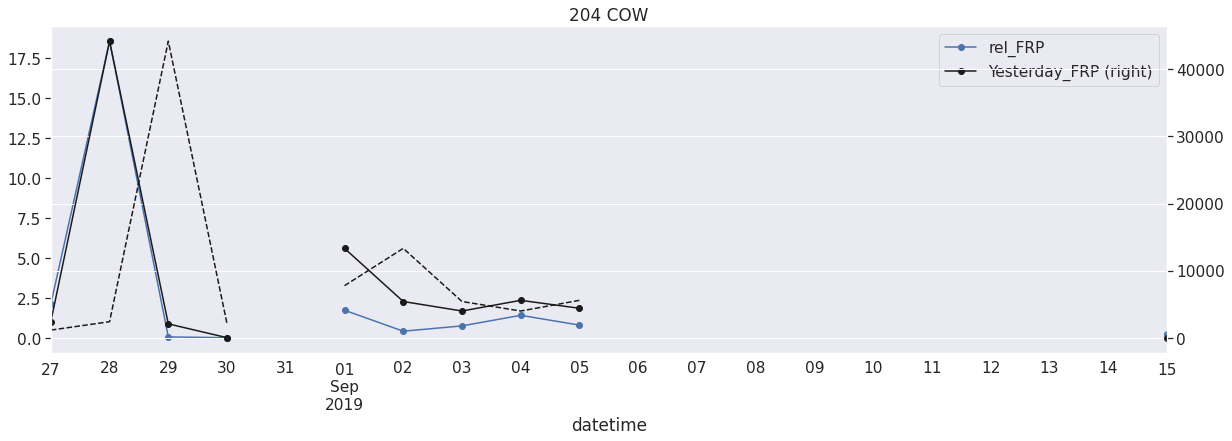

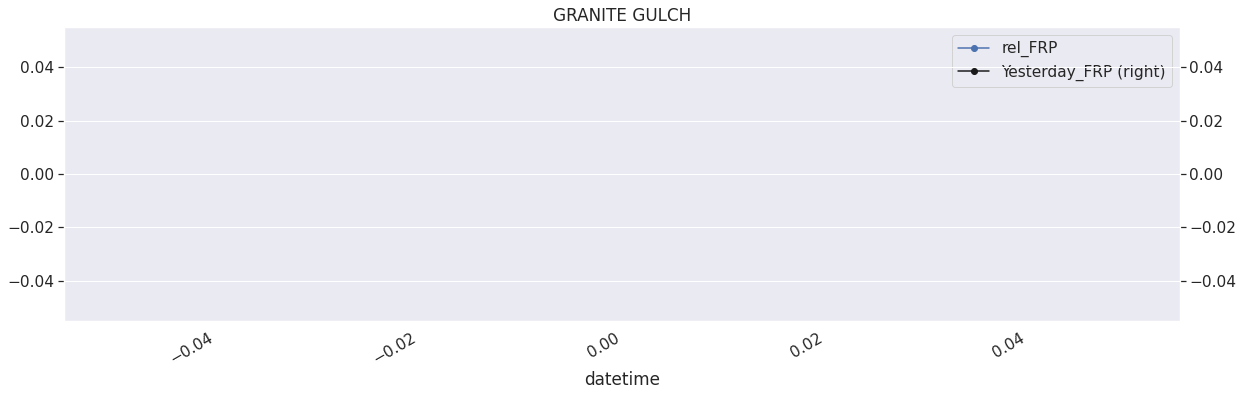

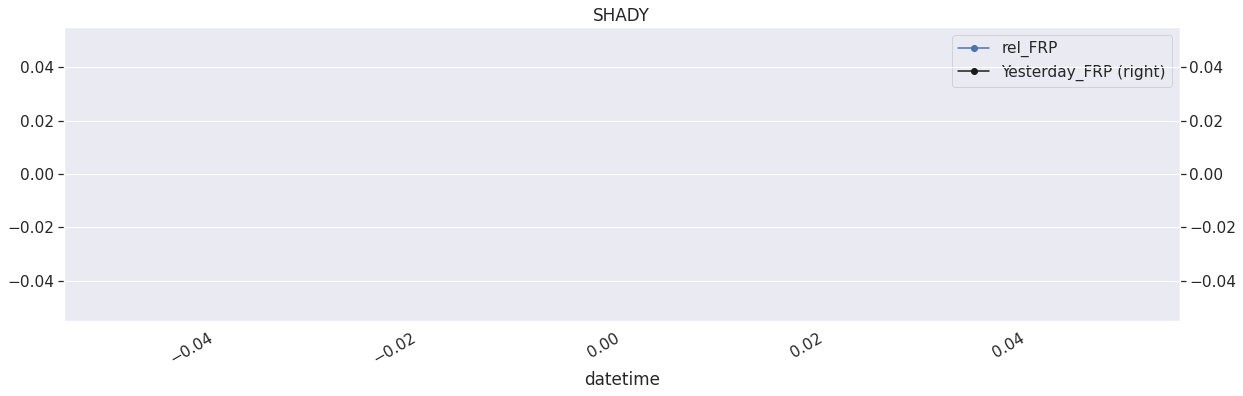

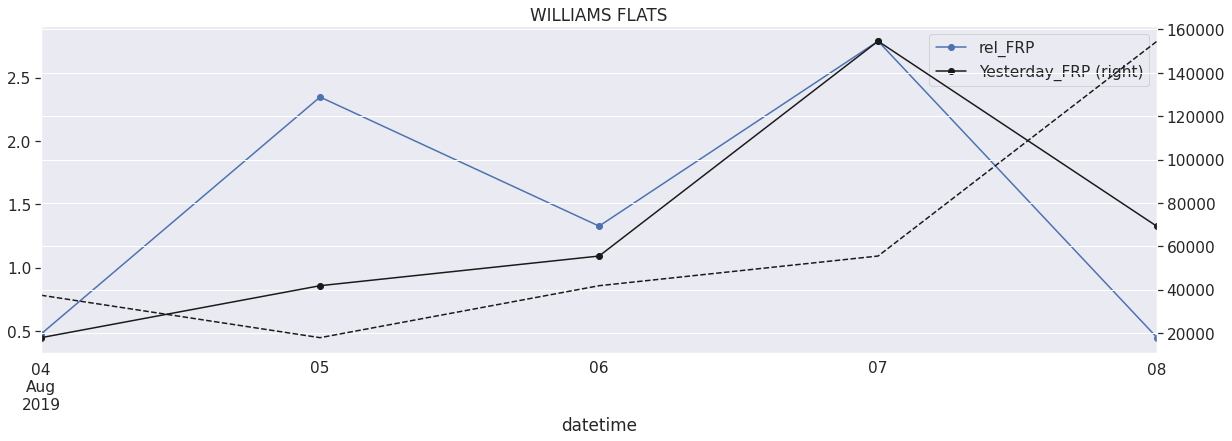

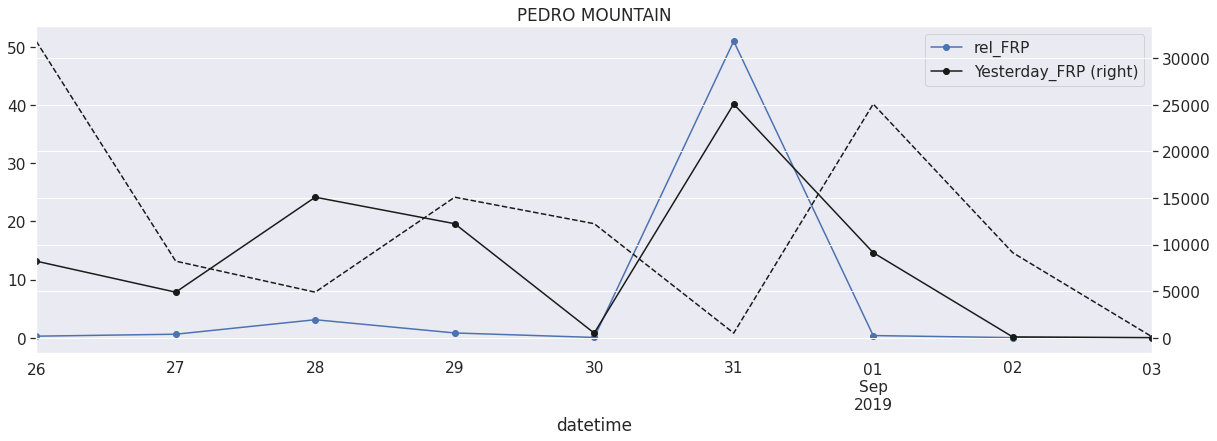

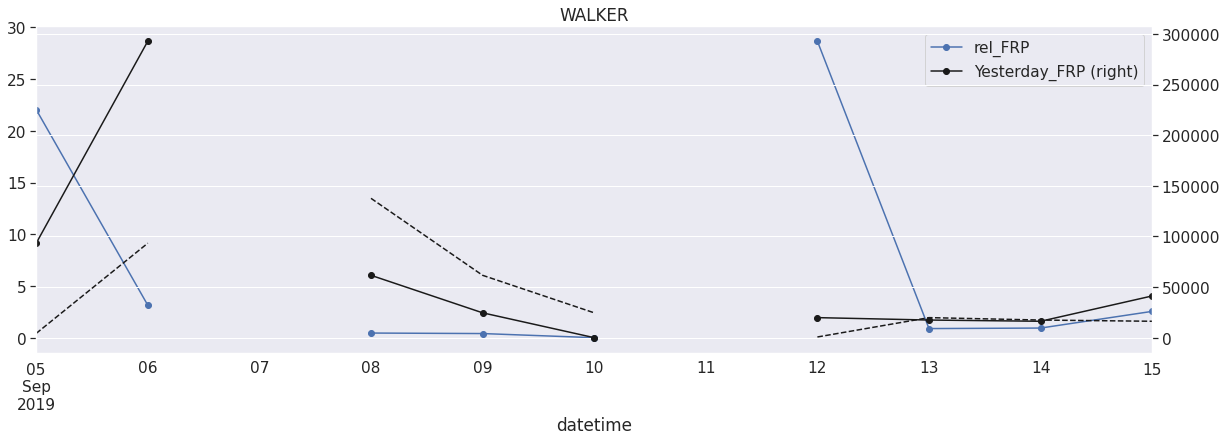

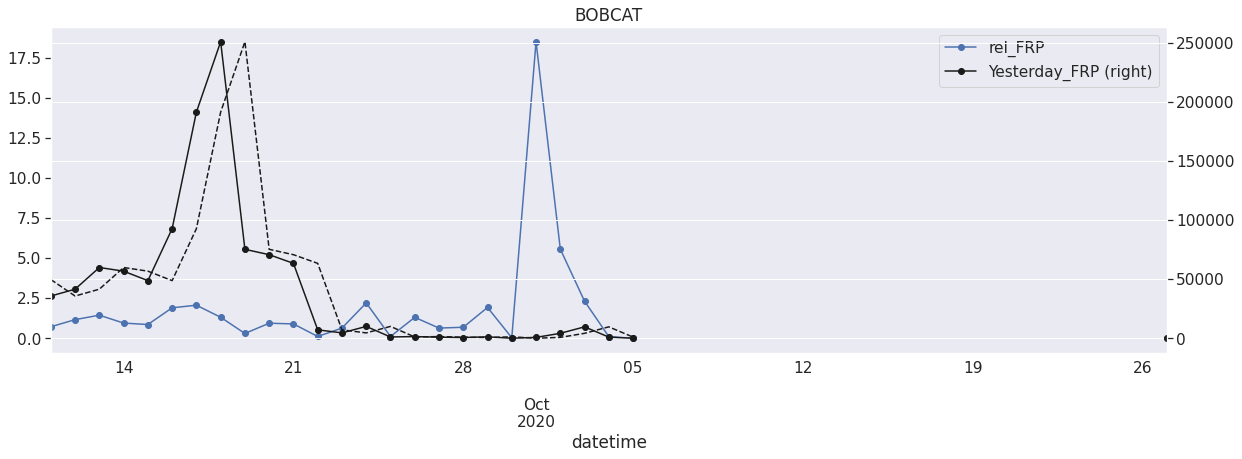

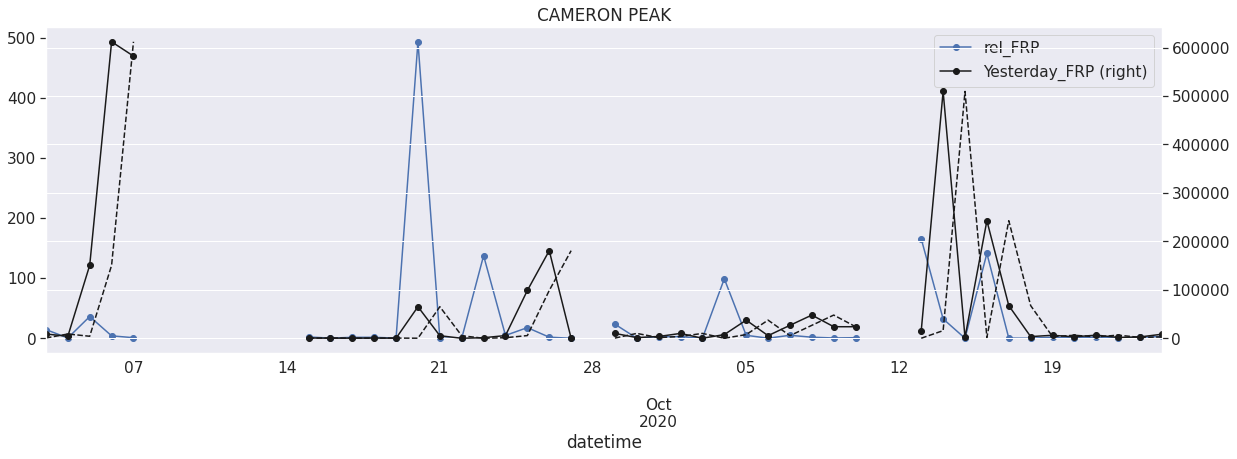

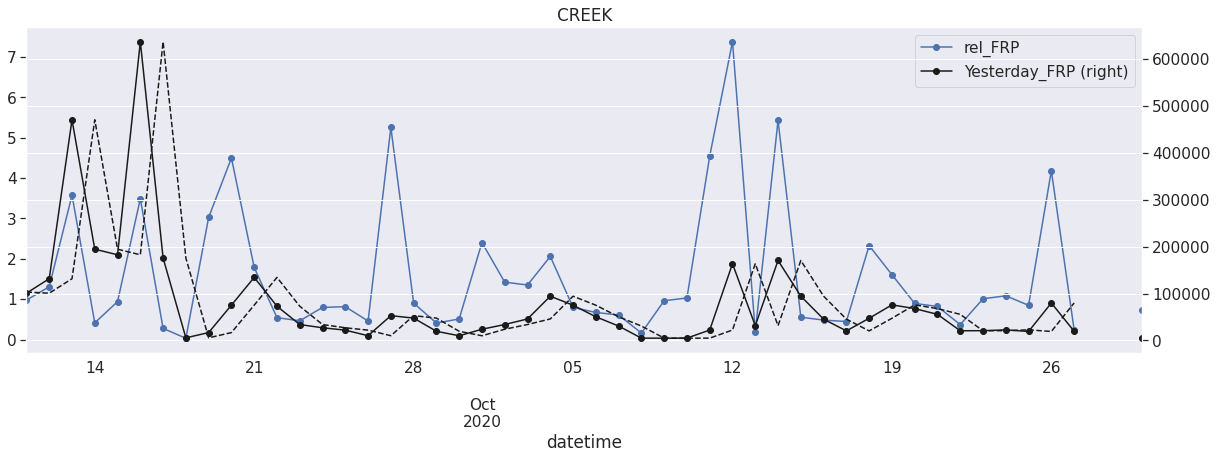

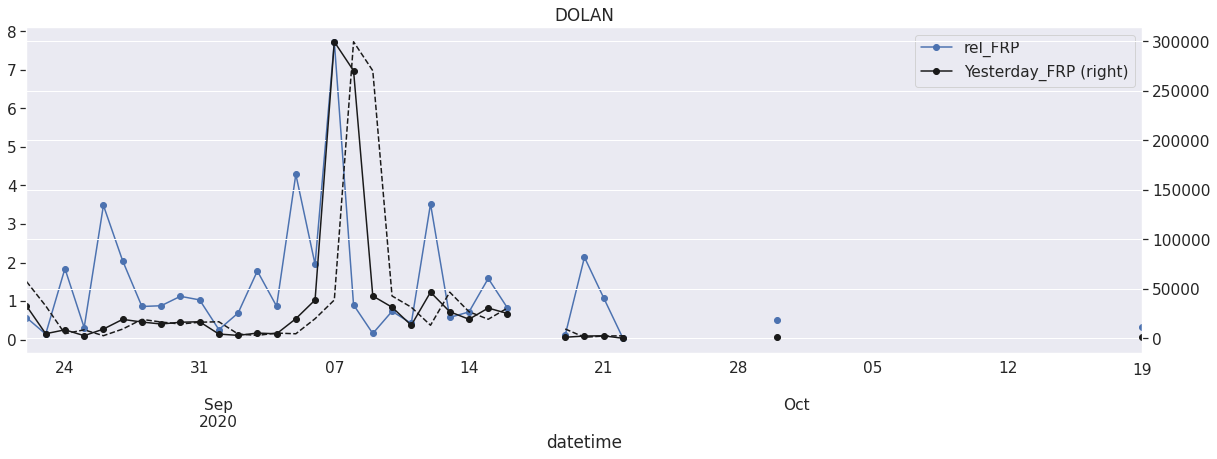

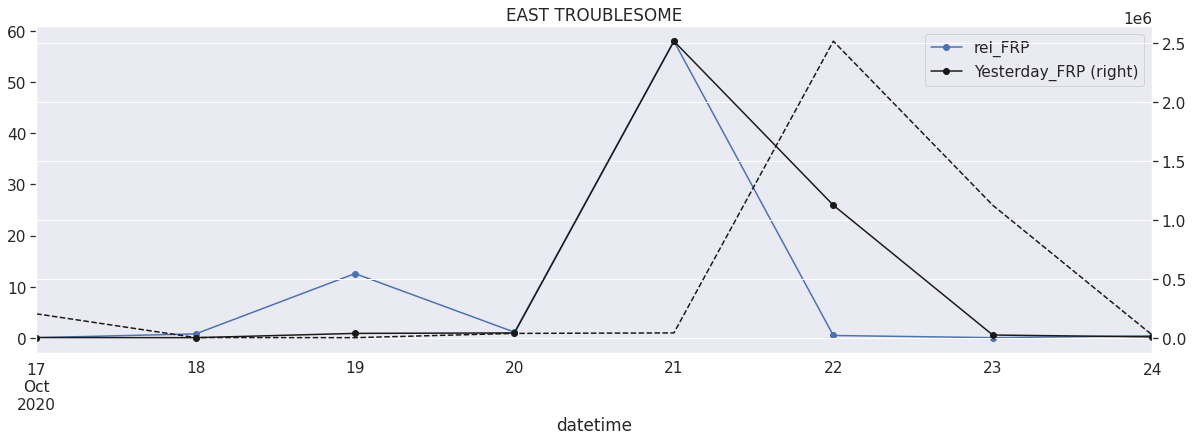

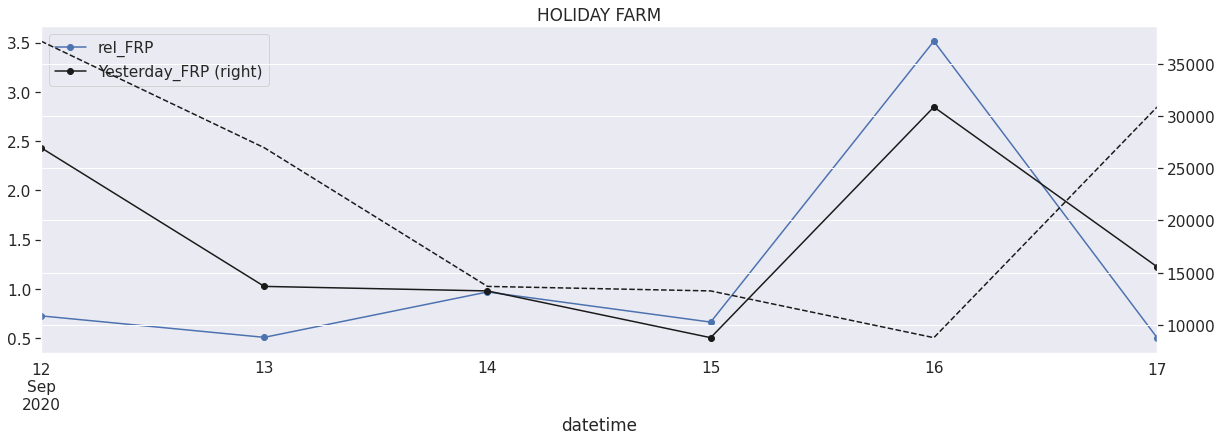

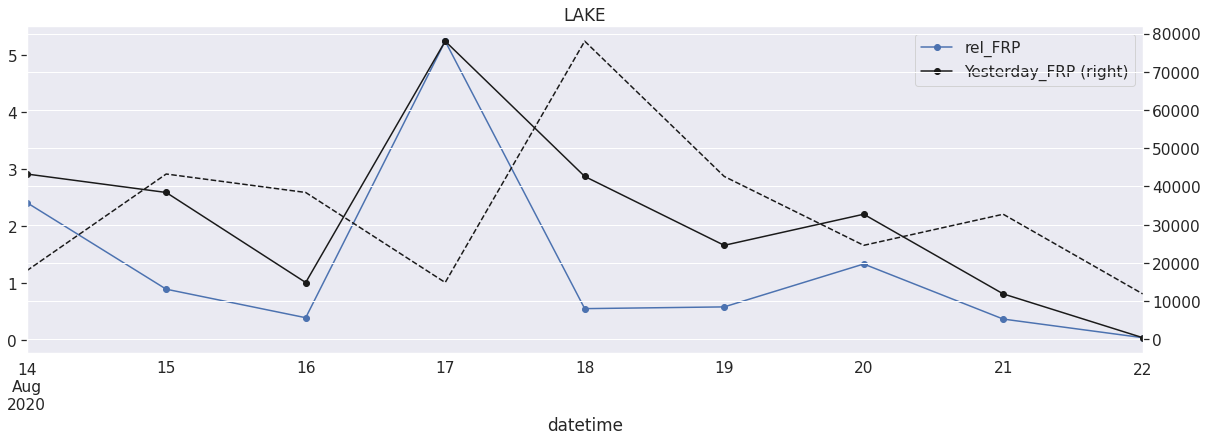

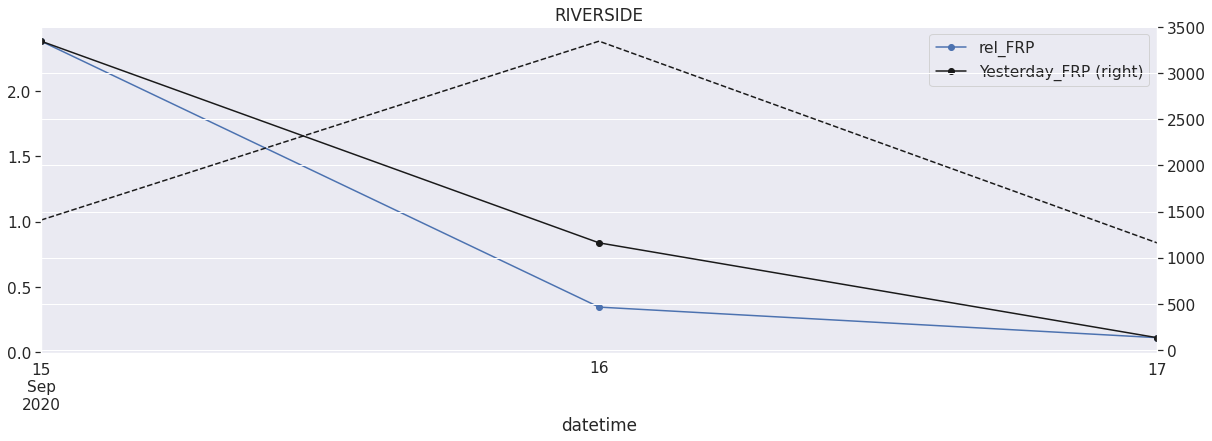

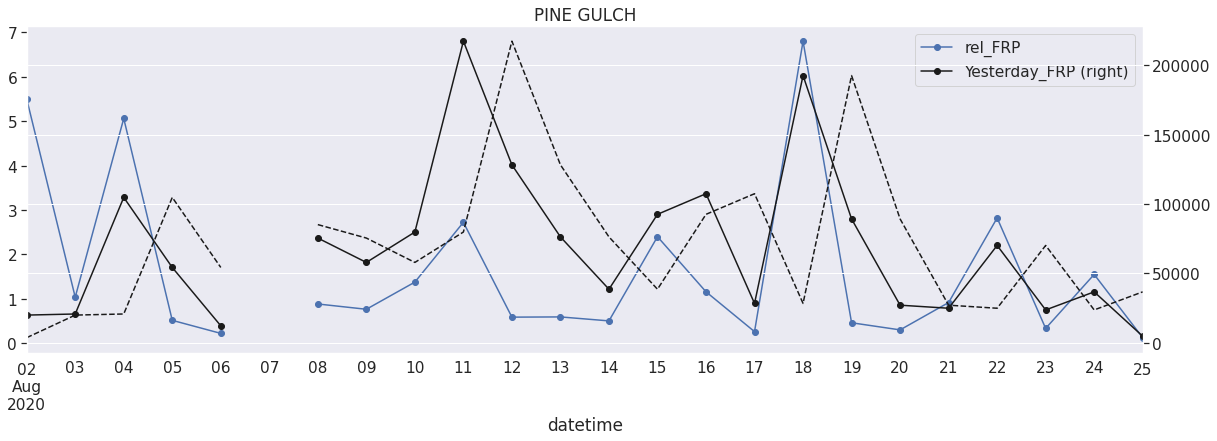

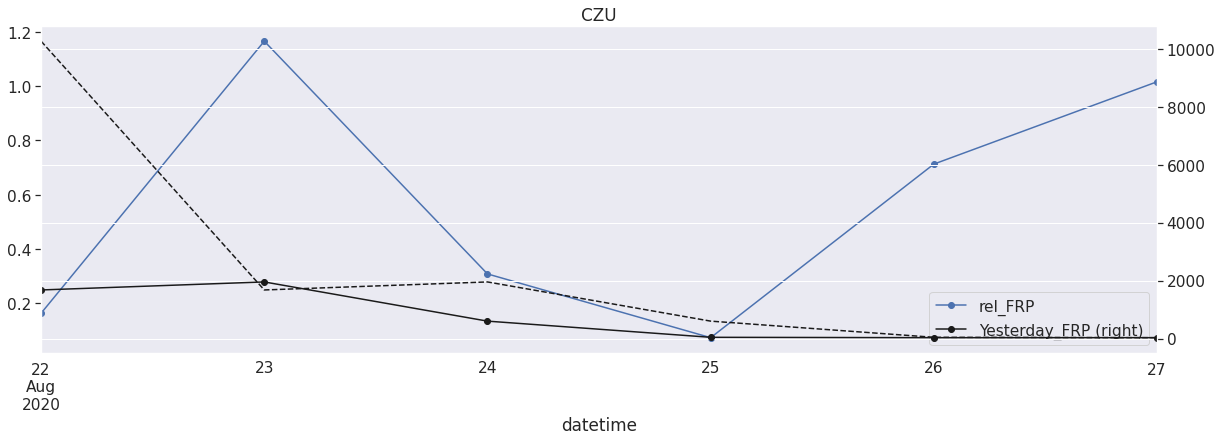

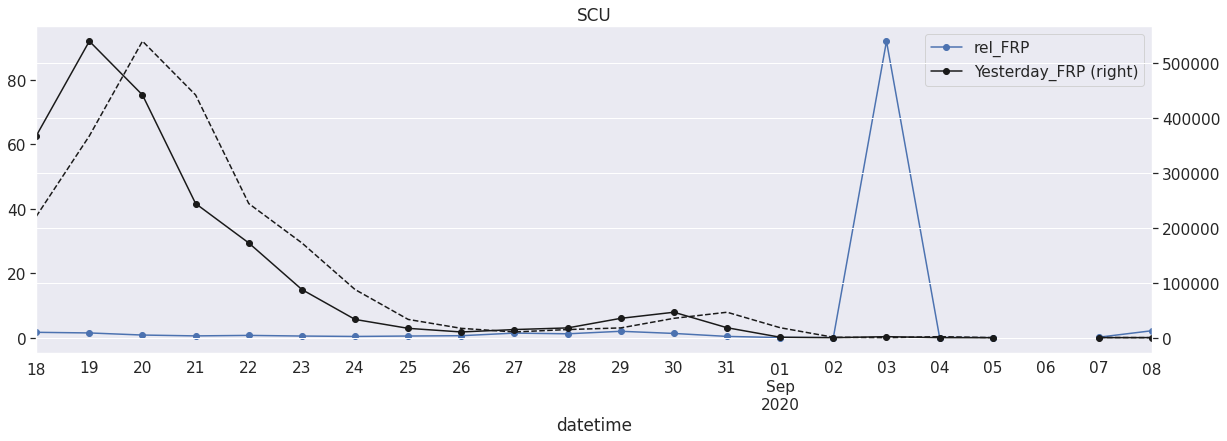

In [25]:
#line plots

for ii in range(len(inci_train)):
    fire_plot = resample_daily(data_train_nonan[data_train_nonan['name']==inci_train[ii]], 'datetime')
    fig, ax = plt.subplots(figsize=(20,15)) 
    fire_plot.plot(x='datetime',y=['rel_FRP'],
                            figsize=(20,6),style='o-',ax=ax)
    fire_plot.plot(x='datetime',y=['Yesterday_FRP'],
                            figsize=(20,6),style='k--',ax=ax, secondary_y=True)
    fire_plot.plot(x='datetime',y=['FRP_MEAN'],
                            figsize=(20,6),style='ko-',ax=ax, secondary_y=True)
    plt.title(inci_train[ii])

## Some Automated Feature Selection

varying weather
rel_hd0w0


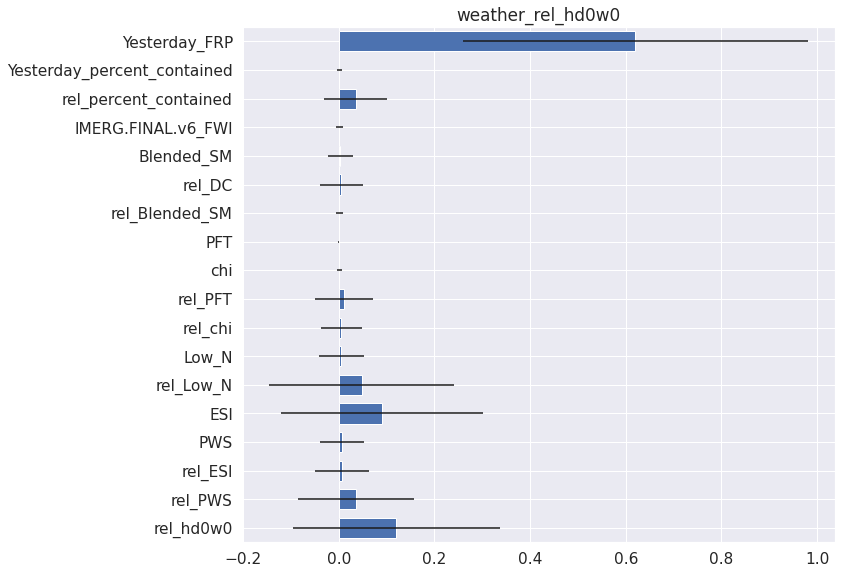

rel_hd1w0


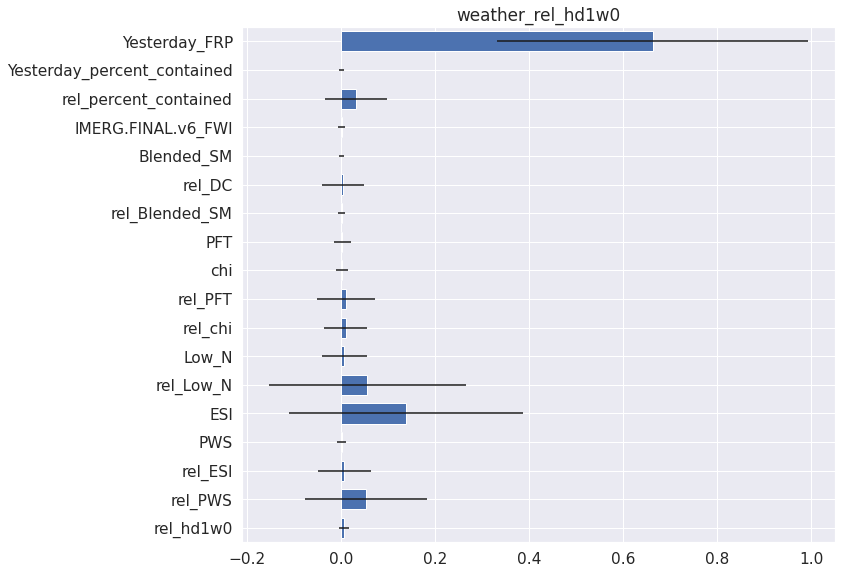

rel_hd2w0


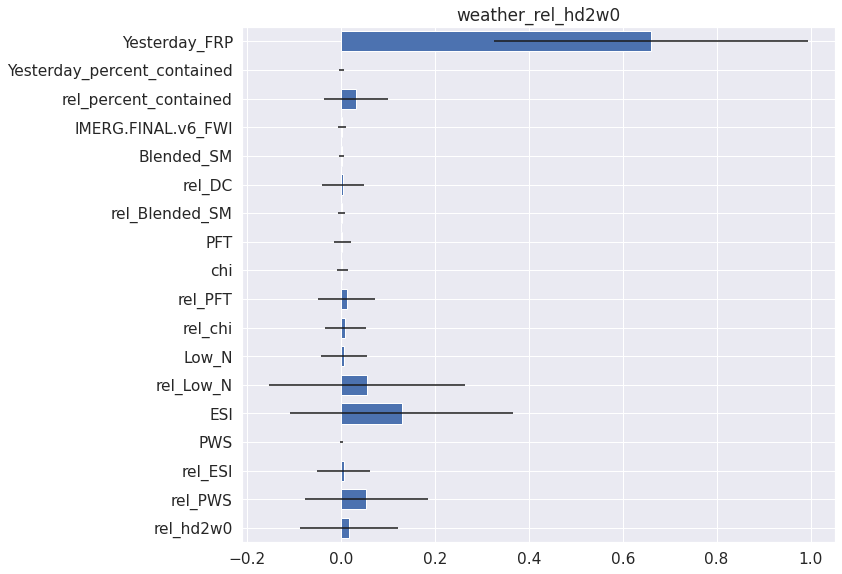

rel_hd3w0


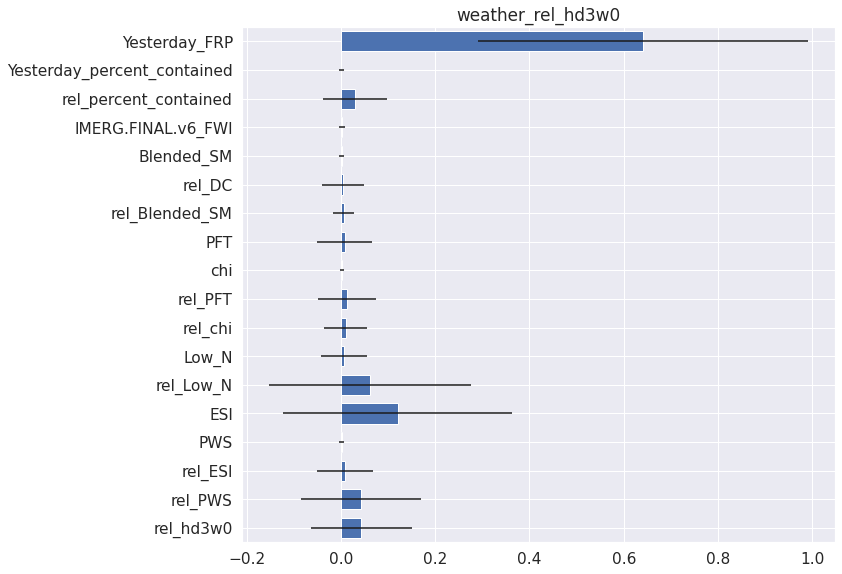

rel_hwp


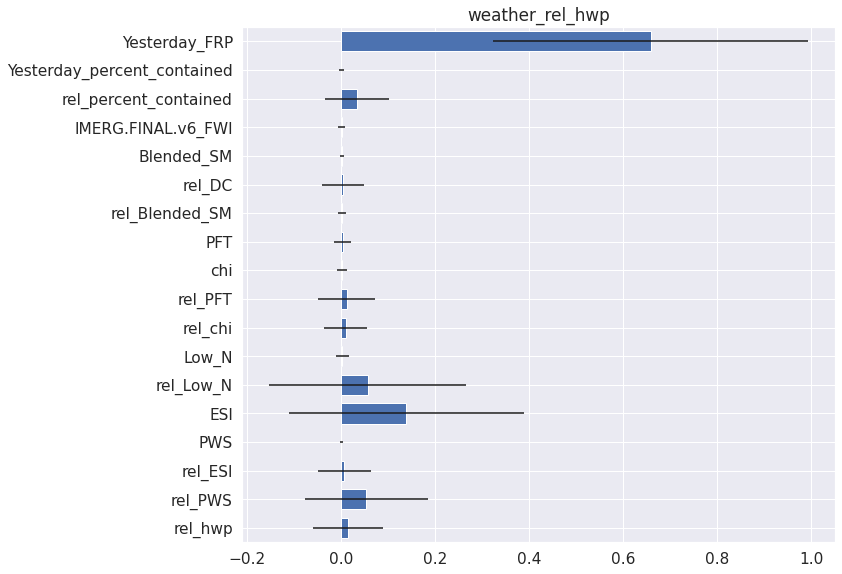

hd0w0


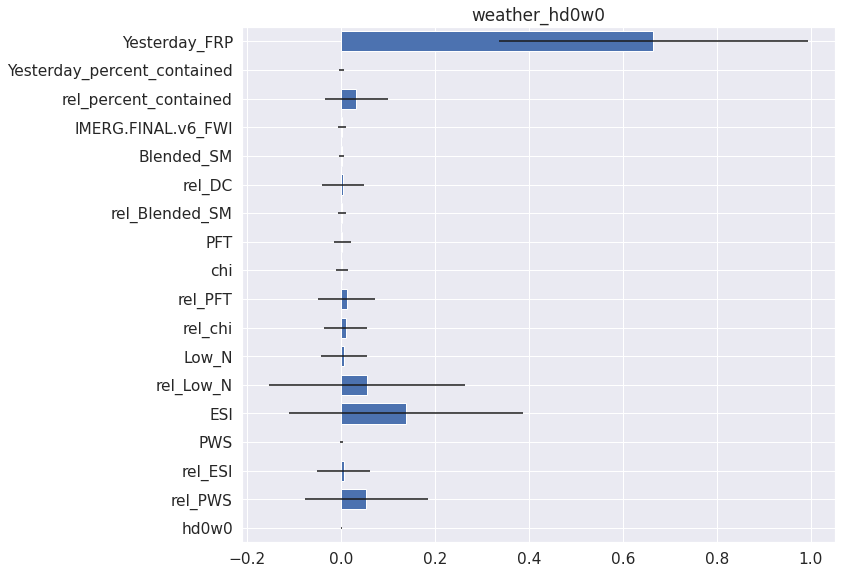

hd1w0


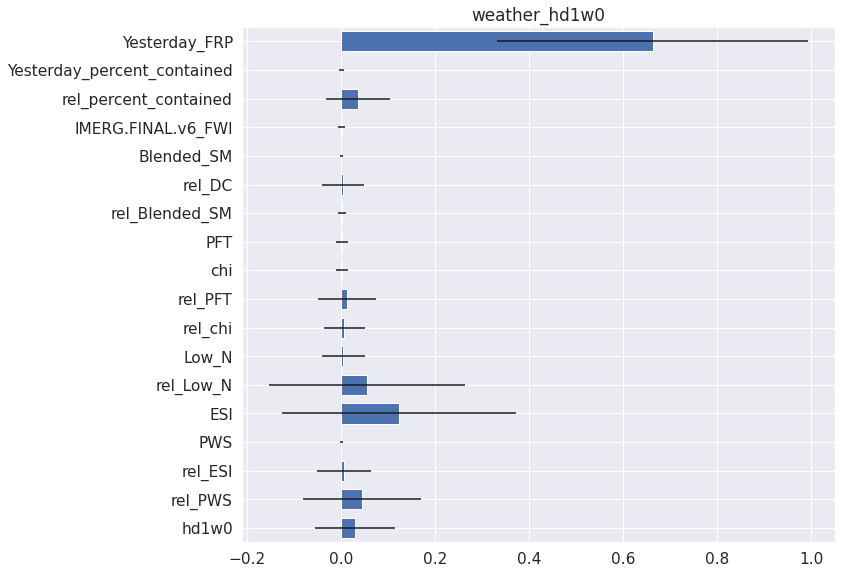

hd2w0


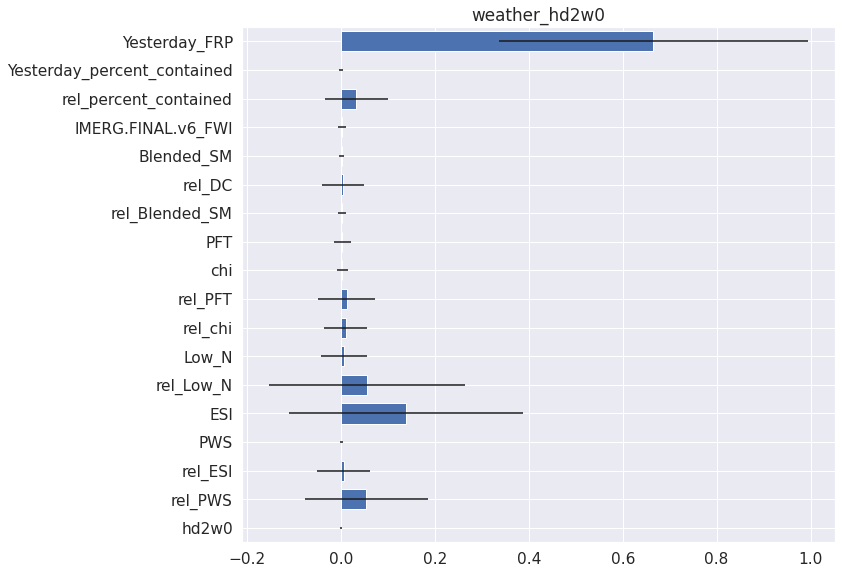

hd3w0


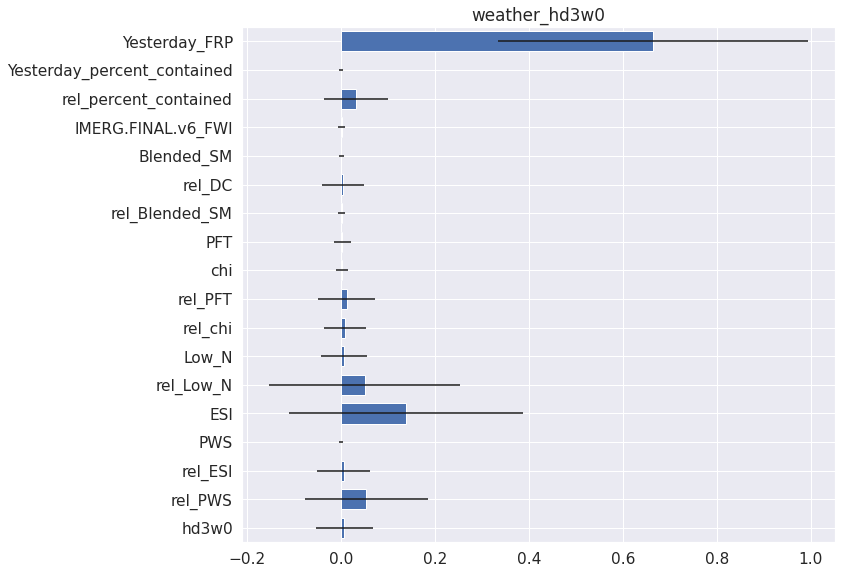

hwp


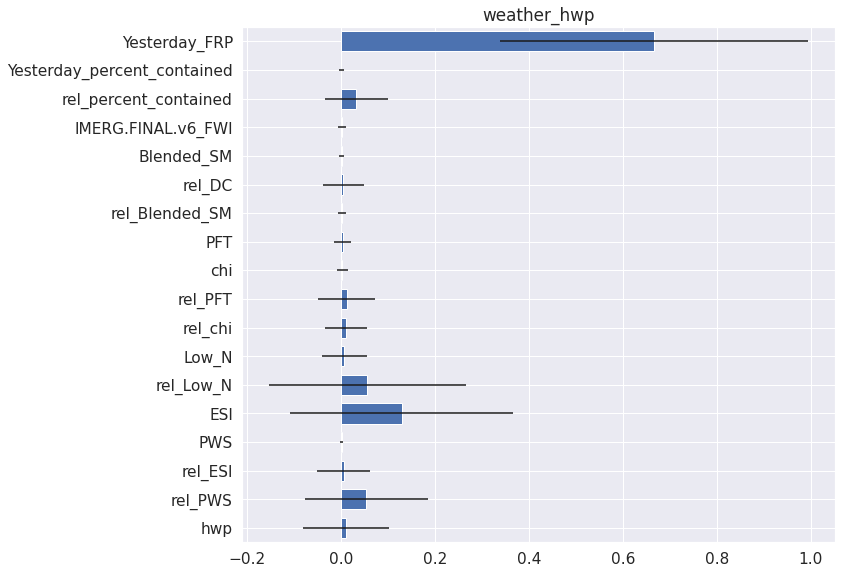


varying ecosystem_characteristics
rel_PWS


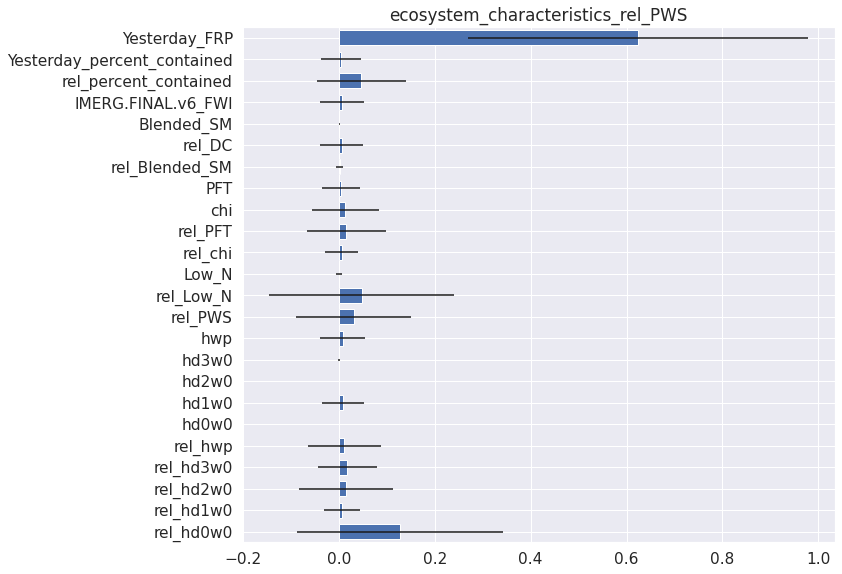

rel_ESI


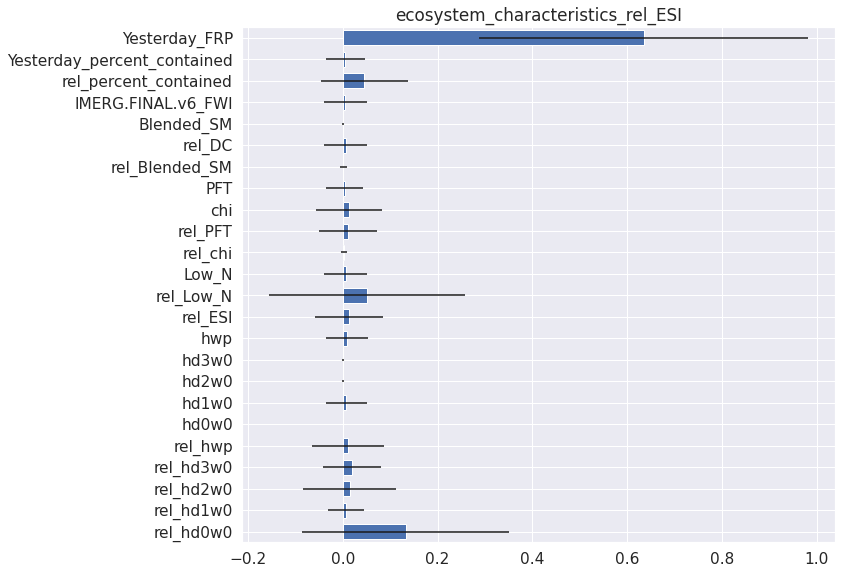

PWS


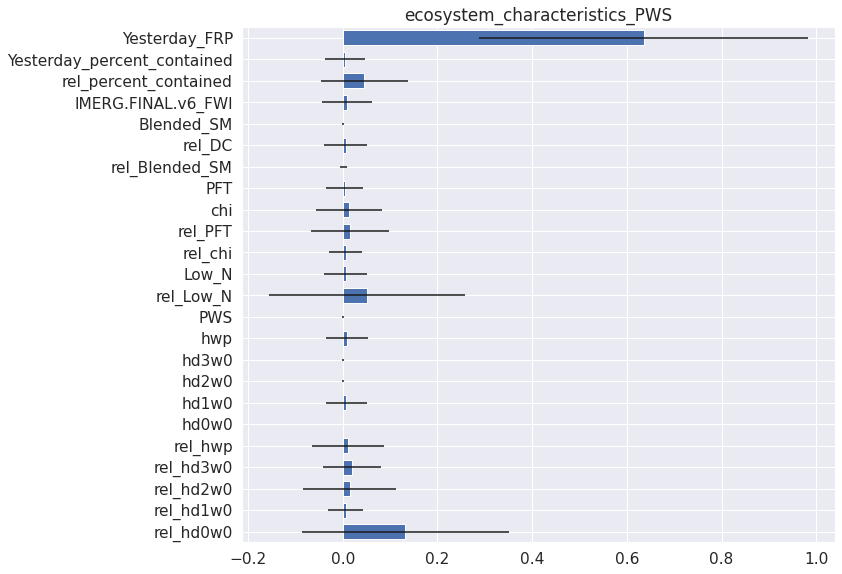

ESI


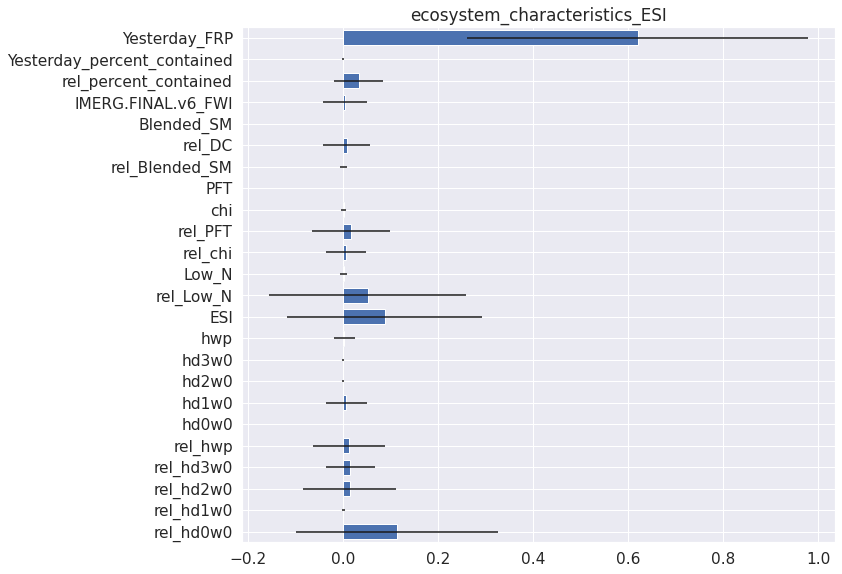


varying fuel_loading
rel_Low_N


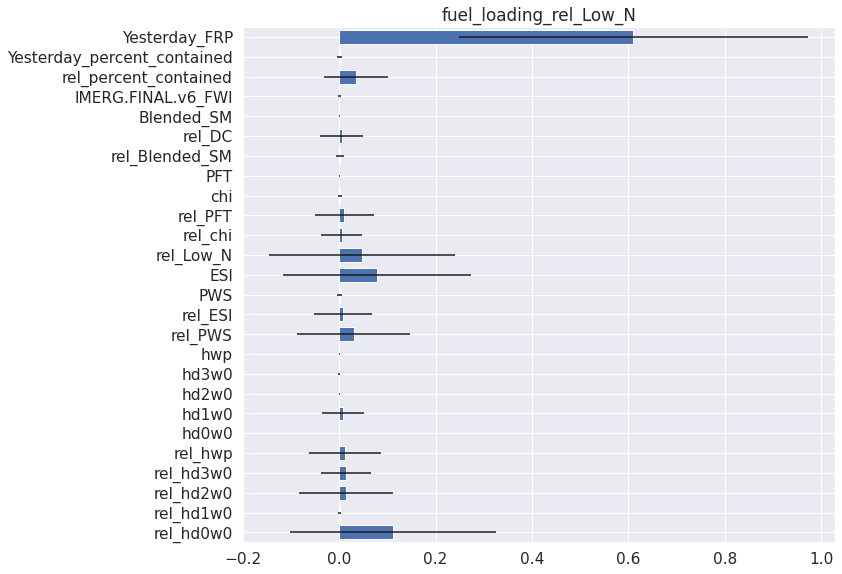

Low_N


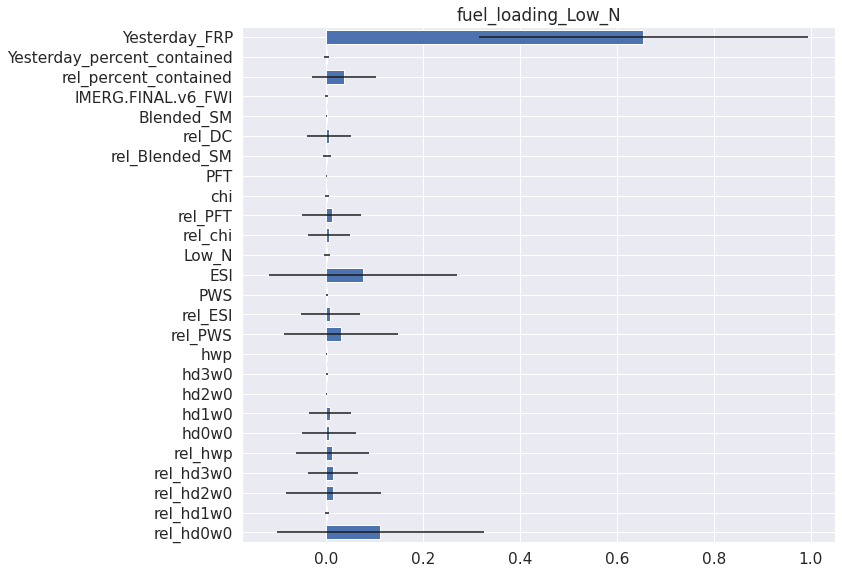


varying stability
rel_chi


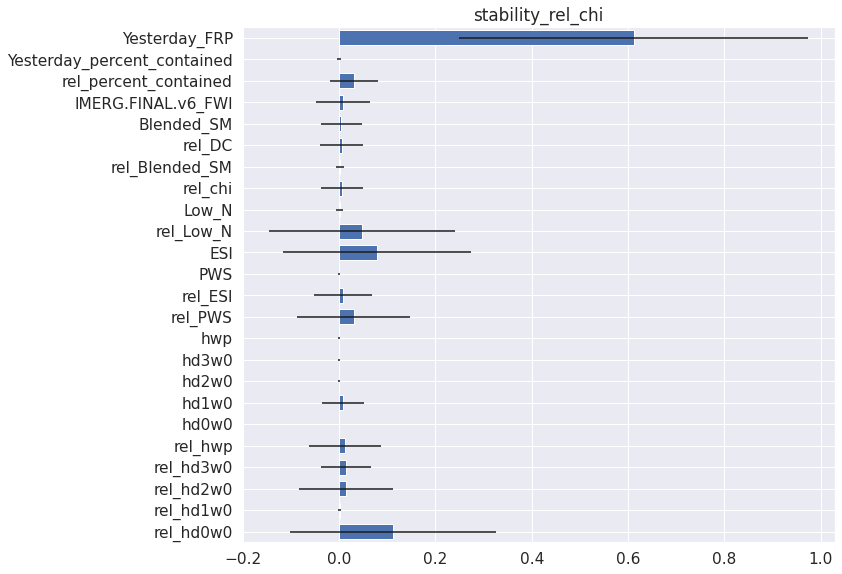

rel_PFT


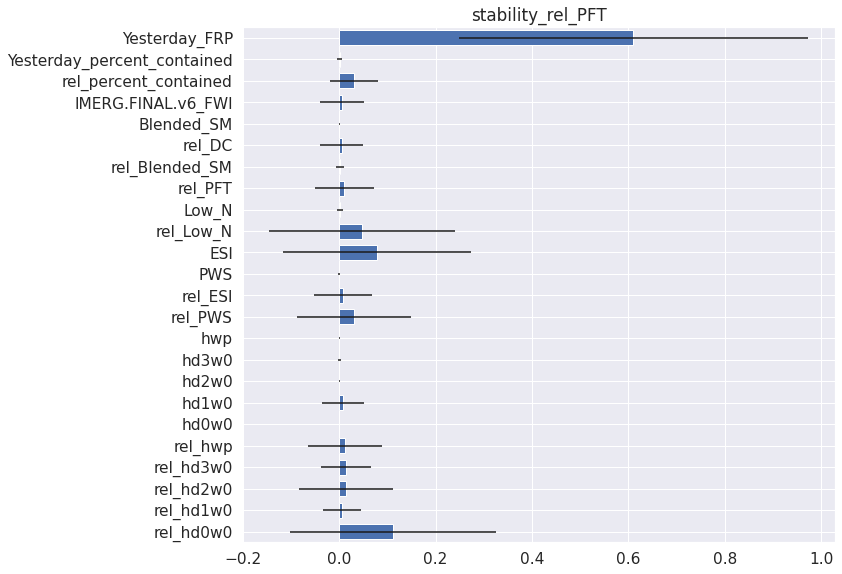

chi


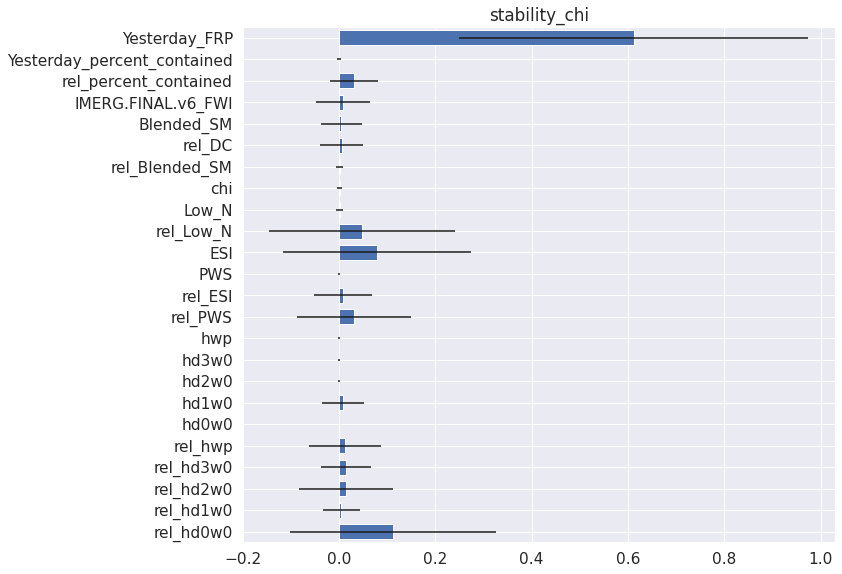

PFT


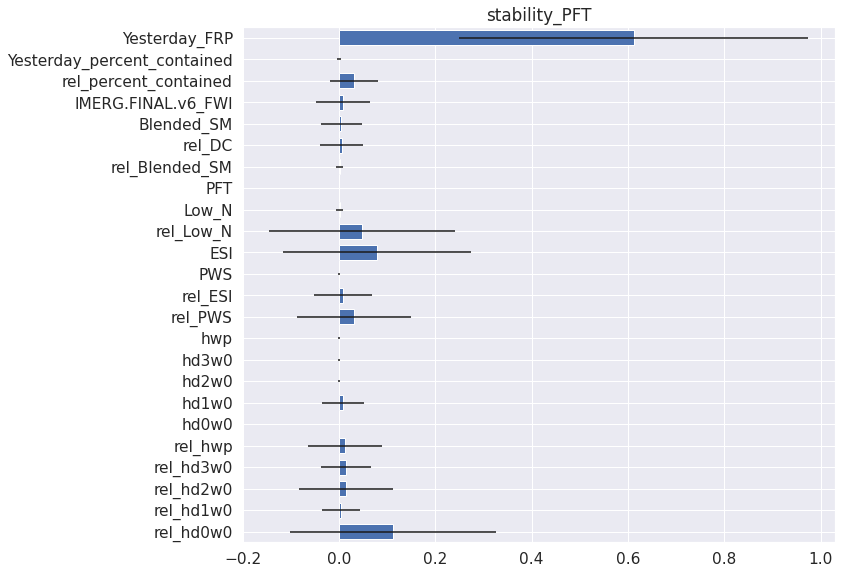


varying moisture
rel_Blended_SM


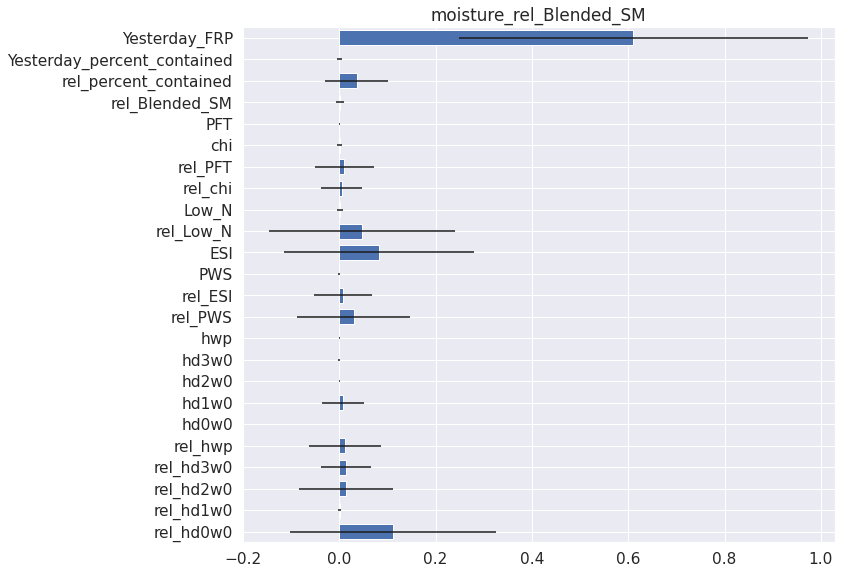

rel_DC


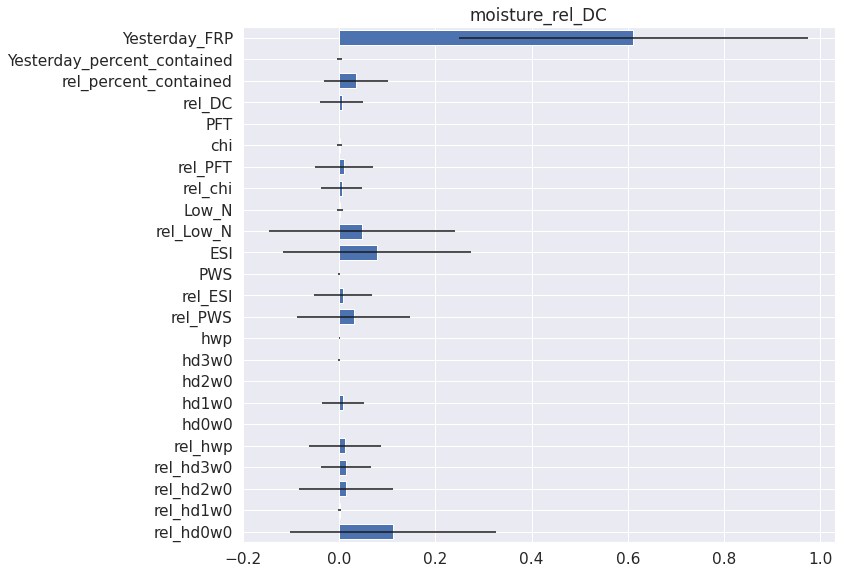

Blended_SM


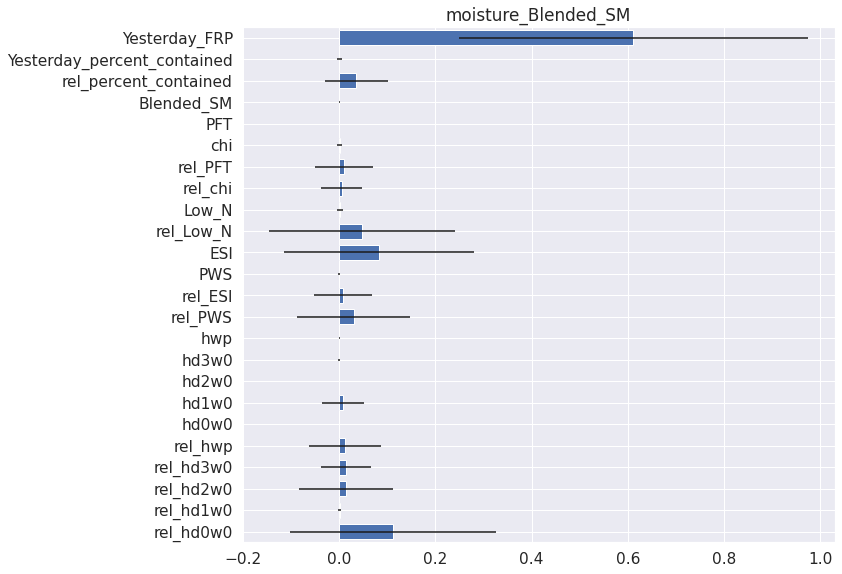

IMERG.FINAL.v6_FWI


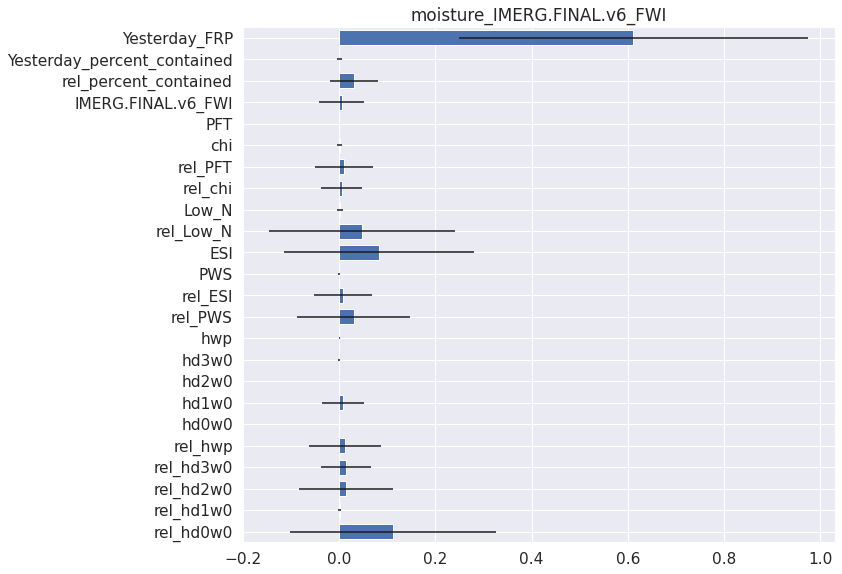


varying firefighting
rel_percent_contained


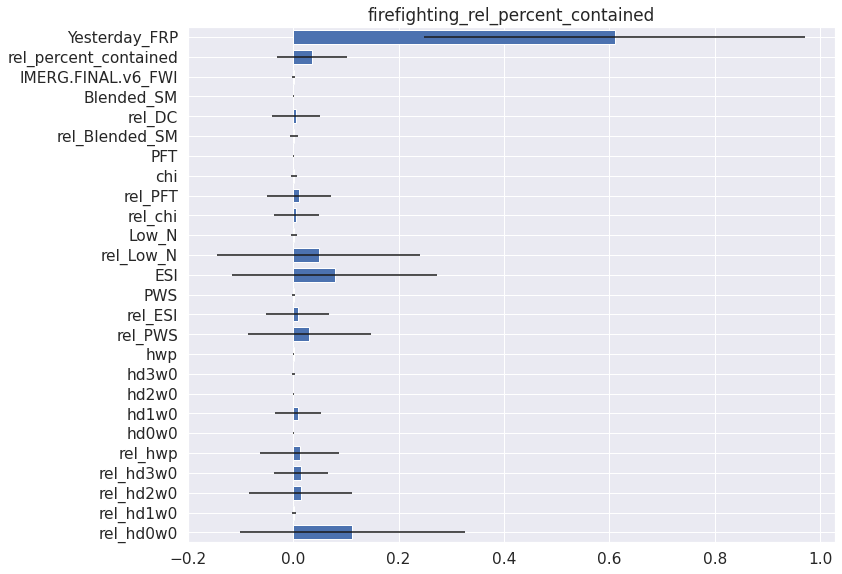

Yesterday_percent_contained


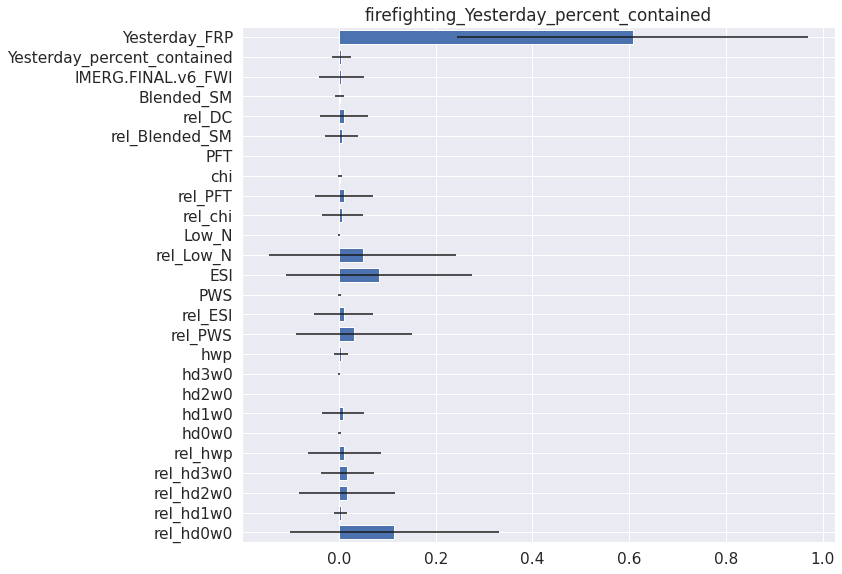


varying persistence
Yesterday_FRP


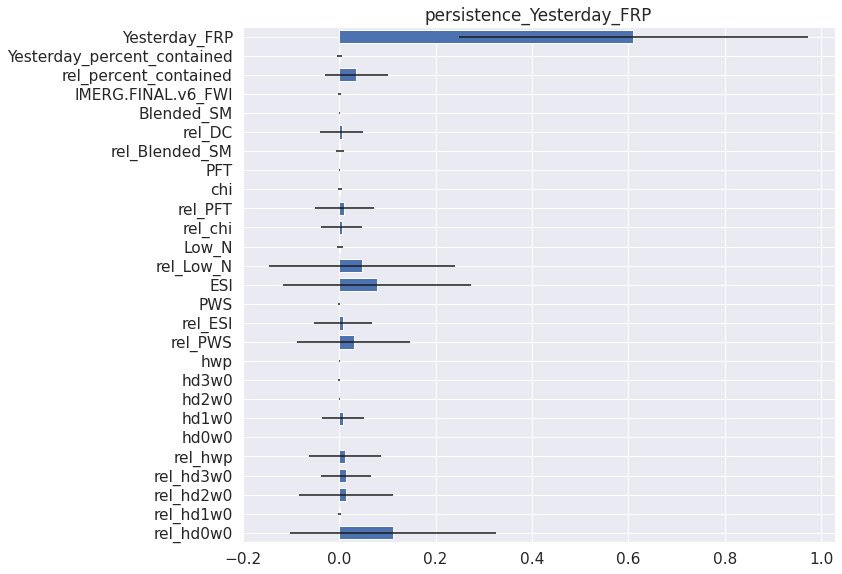


     datetime            name       FRP_MEAN  Yesterday_FRP  \
4  2020-08-21  AUGUST COMPLEX  234039.321614  523870.326291   
5  2020-08-22  AUGUST COMPLEX  153087.045791  234039.321614   
6  2020-08-23  AUGUST COMPLEX   98001.663927  153087.045791   
7  2020-08-24  AUGUST COMPLEX   95478.552329   98001.663927   
8  2020-08-25  AUGUST COMPLEX   79595.082286   95478.552329   
..        ...             ...            ...            ...   
60 2020-10-16  AUGUST COMPLEX    1087.067145    7089.674430   
61 2020-10-17  AUGUST COMPLEX    1212.685336    1087.067145   
62 2020-10-18  AUGUST COMPLEX     717.263412    1212.685336   
63 2020-10-19  AUGUST COMPLEX      39.291415     717.263412   
66 2020-10-22  AUGUST COMPLEX      35.722984       6.500434   

    weather_rel_hd0w0  weather_rel_hd1w0  weather_rel_hd2w0  \
4       313475.074227      361492.921965      397158.975334   
5       270472.315237      192336.553106      232549.133185   
6       314883.803854      329094.172011      199147.

In [15]:
variable_dict = {'weather': ['rel_hd0w0', 'rel_hd1w0','rel_hd2w0','rel_hd3w0','rel_hwp', 
                            'hd0w0', 'hd1w0','hd2w0','hd3w0','hwp',], 
                'ecosystem_characteristics': ['rel_PWS', 'rel_ESI','PWS','ESI'], 
                'fuel_loading':['rel_Low_N', 'Low_N'], 
                'stability': ['rel_chi', 'rel_PFT', 'chi', 'PFT'], 
                'moisture': ['rel_Blended_SM','rel_DC','Blended_SM','IMERG.FINAL.v6_FWI'],
                'firefighting': ['rel_percent_contained','Yesterday_percent_contained'], 
                'persistence': ['Yesterday_FRP']} #this is the list of parameters to vary

#training_variables = 
#print(training_variables)
params_to_vary = list(variable_dict.keys())


frps_compare = pd.DataFrame(data_test_nonan[['datetime','name','FRP_MEAN', 'Yesterday_FRP']])

for item in params_to_vary: #this loop is where we change the kind of variable that is changing
    print('varying '+ item)
    
    for dont_drop in variable_dict[item]: #this loop changes the varaible itself
        print(dont_drop)
        to_drop = list(variable_dict[item])
        to_drop.remove(dont_drop) #this list contains the items we want dropped (all but the variable we are testing)
        variable_list = list(variable_dict.values())
        tv = [thing for sublist in variable_list for thing in sublist]
        for thing_to_remove in to_drop:
            tv.remove(thing_to_remove)
        
        #print(tv)
        
        #do the machine learning
        rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) 
        rf.fit(data_train_nonan.loc[:, tv], data_train_nonan.loc[:, ['rel_FRP']].values.ravel())
        rf_frp = rf.predict(data_test_nonan.loc[:,tv])
        
        frps_compare[item+'_'+dont_drop] = rf_frp*frps_compare['Yesterday_FRP']
        
        plot_importances(rf, tv,item+'_'+dont_drop)

        
        
    print()
print(frps_compare)

In [22]:
#get the optimal subset of relative and absolute features
tv = ['rel_hd0w0','rel_hd1w0','rel_hd3w0', 'rel_hwp', #weather
     'rel_PWS', 'ESI', 
     'rel_Low_N', 
     'rel_PFT',
     'rel_DC', 'rel_Blended_SM',
     'rel_percent_contained',
     'Yesterday_FRP']

rf = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state=42) 
rf.fit(data_train_nonan.loc[:, tv], data_train_nonan.loc[:, ['rel_FRP']].values.ravel())
rf_frp = rf.predict(data_test_nonan.loc[:,tv])
frps_compare['optimal'] = rf_frp*frps_compare['Yesterday_FRP']

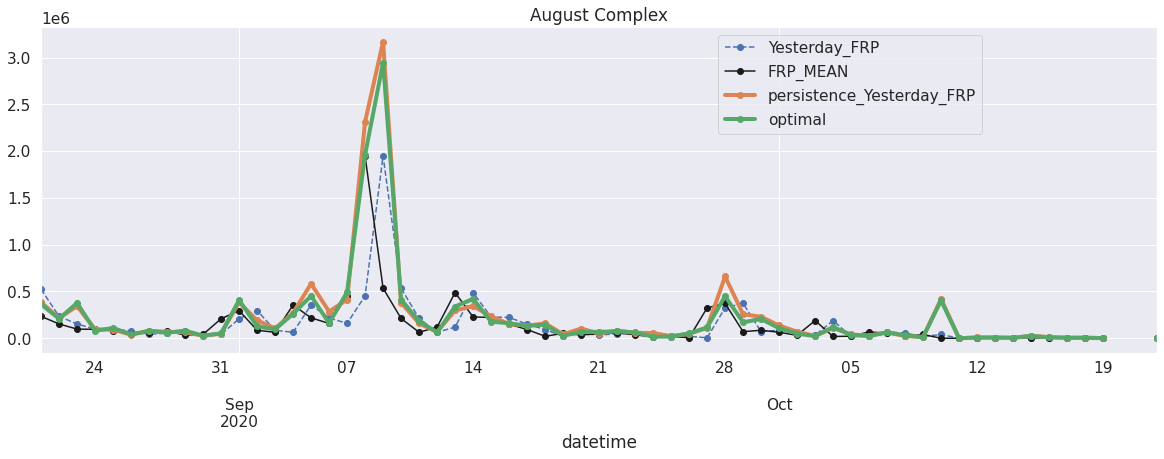

In [23]:
labels_plot = resample_daily(frps_compare[frps_compare['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
labels_plot.plot(x='datetime', y=['persistence_Yesterday_FRP', 'optimal'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title('August Complex')
plt.show() 

## Experiment with features by hand

### this shows why we need to predict the scaling factor

In [ ]:
tv_op=['rel_hwp',#weather
        'PWS', 'ESI', #Soil/fuel characteristics
        'PFT',#stability
                    'Low_N',#fuel 
                    'Blended_SM','IMERG.FINAL.v6_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence"""
tv_ks=['hwp', #weather
        'PWS', 'ESI', #Soil/fuel characteristics
        'PFT',#stability
        'Low_N',#fuel 
        'Blended_SM','IMERG.FINAL.v6_DC', #moisture
        'Yesterday_percent_contained', #firefighting, 
        'Yesterday_FRP'] #persistence


rf_ks = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_ks.fit(data_train_nonan.loc[:, tv_ks], data_train_nonan.loc[:, ['rel_FRP']])
rf_frp_ks = rf_ks.predict(data_test_nonan.loc[:,tv_ks])

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['rel_FRP']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
labels_test['RF_FRP_KS'] = labels_test['Yesterday_FRP']*rf_frp_ks
labels_test['RF_FRP_OP'] = labels_test['Yesterday_FRP']*rf_frp_op

labels_test['FRP1_rel_hwp'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']

for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_KS','RF_FRP_OP', 'FRP1_rel_hwp'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

    
plot_importances(rf_op, tv_op,'Optimized RF')
plot_importances(rf_ks, tv_ks,'Kitchen Sink RF')

### dot

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


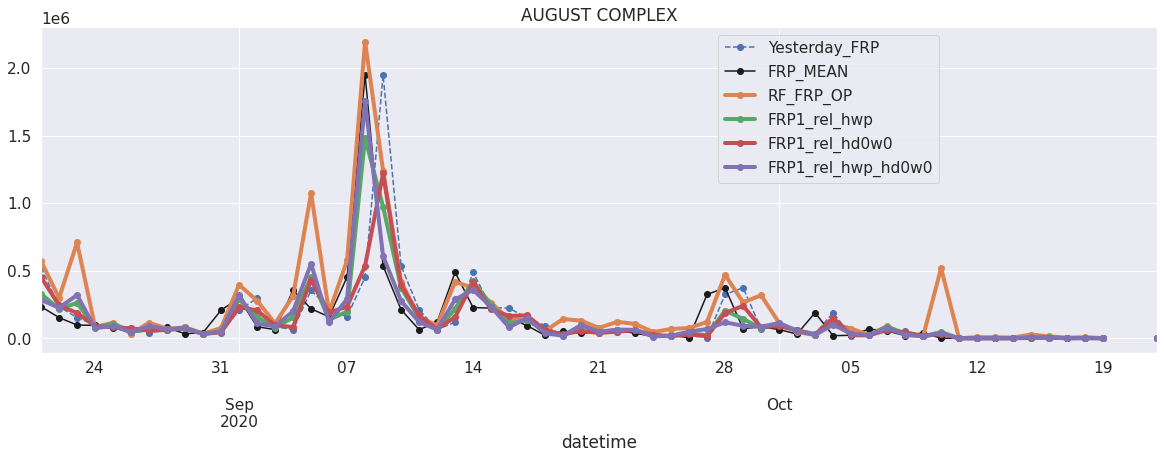

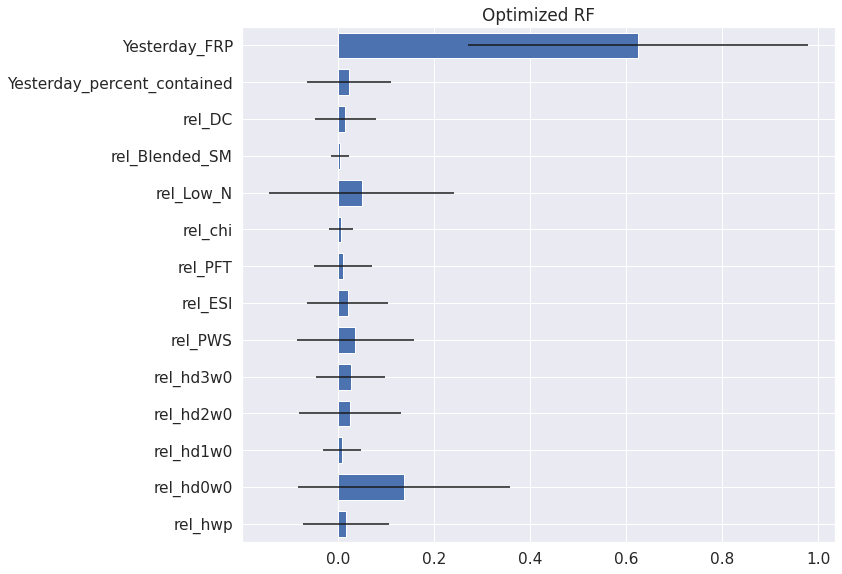

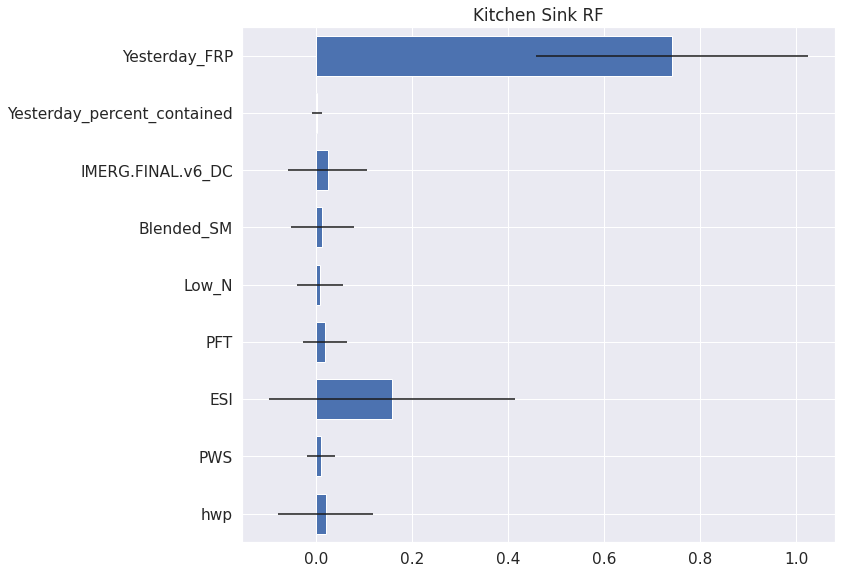

In [11]:
tv_op=['rel_hwp','rel_hd0w0','rel_hd1w0','rel_hd2w0','rel_hd3w0',#weather
        'rel_PWS', 'rel_ESI', #Soil/fuel characteristics
        'rel_PFT','rel_chi',#stability
        'rel_Low_N',#fuel 
        'rel_Blended_SM','rel_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence"""
tv_ks=['hwp', #weather
        'PWS', 'ESI', #Soil/fuel characteristics
        'PFT',#stability
        'Low_N',#fuel 
        'Blended_SM','IMERG.FINAL.v6_DC', #moisture
        'Yesterday_percent_contained', #firefighting, 
        'Yesterday_FRP'] #persistence


rf_ks = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_ks.fit(data_train_nonan.loc[:, tv_ks], data_train_nonan.loc[:, ['rel_FRP']])
rf_frp_ks = rf_ks.predict(data_test_nonan.loc[:,tv_ks])

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['rel_FRP']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
labels_test['rel_FRP_ks'] = rf_frp_ks
labels_test['rel_FRP_op'] = rf_frp_op
labels_test['RF_FRP_KS'] = labels_test['Yesterday_FRP']*rf_frp_ks
labels_test['RF_FRP_OP'] = labels_test['Yesterday_FRP']*rf_frp_op

labels_test['FRP1_rel_hwp'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']
labels_test['FRP1_rel_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hd0w0']
labels_test['FRP1_rel_hwp_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']*labels_test['rel_hd0w0']



for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_OP', 'FRP1_rel_hwp', 'FRP1_rel_hd0w0', 'FRP1_rel_hwp_hd0w0'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

plot_importances(rf_op, tv_op,'Optimized RF')
plot_importances(rf_ks, tv_ks,'Kitchen Sink RF')

In [ ]:
labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
#plot the predictions
fig, ax = plt.subplots(figsize=(20,15)) 
labels_plot.plot(x='datetime', y=['rel_FRP'],
                                figsize=(20,6),style='ko-',linewidth=4,ax=ax )
labels_plot.plot(x='datetime', y=['rel_FRP_ks', 'rel_FRP_op'],
                                figsize=(20,6),style='o-',linewidth=2,ax=ax)
    

#h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
plt.title(inci_test[ii])
plt.ylim([0, 100])
plt.show() 

In [ ]:

#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['FRP_MEAN'].values)
thresh_op, accuracies_op = REC(labels_test['RF_FRP_OP'].values, labels_test['FRP_MEAN'].values)
thresh_ks, accuracies_ks = REC(labels_test['RF_FRP_KS'].values, labels_test['FRP_MEAN'].values)
thresh_sc_hwp, accuracies_sc_hwp = REC(labels_test['FRP1_rel_hwp'].values, labels_test['FRP_MEAN'].values)
thresh_sc_hd0w0, accuracies_sc_hd0w0 = REC(labels_test['FRP1_rel_hd0w0'].values, labels_test['FRP_MEAN'].values)
thresh_sc_hwp_hd0w0, accuracies_sc_hwp_hd0w0 = REC(labels_test['FRP1_rel_hwp_hd0w0'].values, labels_test['FRP_MEAN'].values)



forecast_names = ['Yesterday_FRP', 'RF_FRP_OP', 'FRP1_rel_hwp', 'FRP1_rel_hd0w0', 'FRP1_rel_hwp_hd0w0']
truth = 'FRP_MEAN'
benchmark = 'Yesterday_FRP'
for name in forecast_names:
    print(name)
    print('RMSE: '+ str(RMSE(labels_test[name], labels_test[truth])))
    print('MAD: '+ str(MAD(labels_test[name], labels_test[truth])))
    print('MDRAE: ' + str(mdrae(labels_test[truth],labels_test[name],labels_test[benchmark])))
    print('Fractional Error: '+ str(fractional_error(labels_test[name], labels_test[truth])))
    print()

print()
print('AUC')
print('Persistence score is: ' + str(AUC(accuracy_persistence)))
print('Optimized Model score is: ' + str(AUC(accuracies_op)))
print('Kitchen Sink score is: ' + str(AUC(accuracies_ks)))
print('FRP Scaled with HWP score is: ' + str(AUC(accuracies_sc_hwp)))
print('FRP Scaled with HD0W0 score is: ' + str(AUC(accuracies_sc_hd0w0)))
print('FRP Scaled with HWP and HDW score is: ' + str(AUC(accuracies_sc_hwp_hd0w0)))

print()




plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_op, accuracies_op,'b-',linewidth=4,label='Optimized')
plt.plot(thresh_ks, accuracies_ks,'g-',linewidth=4, label='Kitchen Sink')
plt.plot(thresh_sc_hwp, accuracies_sc_hwp, '-', linewidth=2, label='FRP Scaled with HWP')
plt.plot(thresh_sc_hd0w0, accuracies_sc_hd0w0, '-', linewidth=2, label='FRP Scaled with HD0W0')
plt.plot(thresh_sc_hwp_hd0w0, accuracies_sc_hwp_hd0w0, '-', linewidth=2, label='FRP Scaled with HWP and HD0W)')


plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


In [ ]:
#r2
print('R2 Score: ')
print('Persistence R2: '+ str(r2_score(labels_test['Yesterday_FRP'], labels_test['FRP_MEAN'])))
print('Optimized R2: '+ str(r2_score(labels_test['RF_FRP_OP'], labels_test['FRP_MEAN'])))
print('Scaled HWP R2: '+ str(r2_score(labels_test['FRP1_rel_hwp'], labels_test['FRP_MEAN'])))
print('Scaled HD0W0 R2: '+ str(r2_score(labels_test['FRP1_rel_hd0w0'], labels_test['FRP_MEAN'])))
print('Scaled HWP and HD0W0 R2: '+ str(r2_score(labels_test['FRP1_rel_hwp_hd0w0'], labels_test['FRP_MEAN'])))

#rolling window
windowsize = 3
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
labels_test.rolling(window=windowsize,center=True).median().plot(y=['FRP_MEAN','Yesterday_FRP', 'RF_FRP_OP', 
                                                                    'FRP1_rel_hwp_hd0w0'],ax=ax[0], 
                                                        style=['b-','r-','g-', 'c-'])
#persistence
rolling_r_pers = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['Yesterday_FRP'])
rolling_r_pers.plot(ax=ax[1], style='r-')

#Kitchen Sink
rolling_r_op = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_OP'])
rolling_r_op.plot(ax=ax[1], style='g-')


"""#HWP Scaled
rolling_r_sc_hwp = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['FRP1_rel_hwp'])
rolling_r_sc_hwp.plot(ax=ax[1], style='m-')
plt.show()

#HD0W0 Scaled
rolling_r_sc_hd0w0 = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['FRP1_rel_hd0w0'])
rolling_r_sc_hd0w0.plot(ax=ax[1], style='y-')
plt.show()"""

#HWP and HD0W0 Scaled
rolling_r_sc_hwp_hd0w0 = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['FRP1_rel_hwp_hd0w0'])
rolling_r_sc_hwp_hd0w0.plot(ax=ax[1], style='c-')
plt.show()

print(np.nanmean(rolling_r_pers.values))
print(np.nanmean(rolling_r_ks.values))
print(np.nanmean(rolling_r_op.values))

print(rolling_r_op.values)
print(rolling_r_sc_hwp_hd0w0.values)

# Test the effect of weighted features vs unweighted features

204_cow
granite_gulch
shady
williams_flats
pedro_mountain
walker
bobcat
cameron_peak
creek
dolan
east_troublesome
holiday_farm
lake
riverside
pine_gulch
czu
scu
august_complex


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


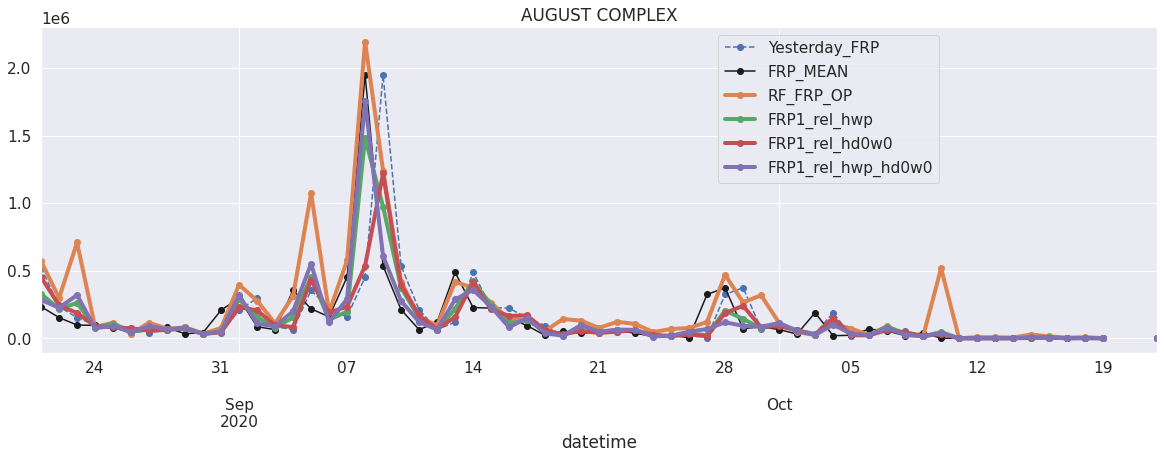

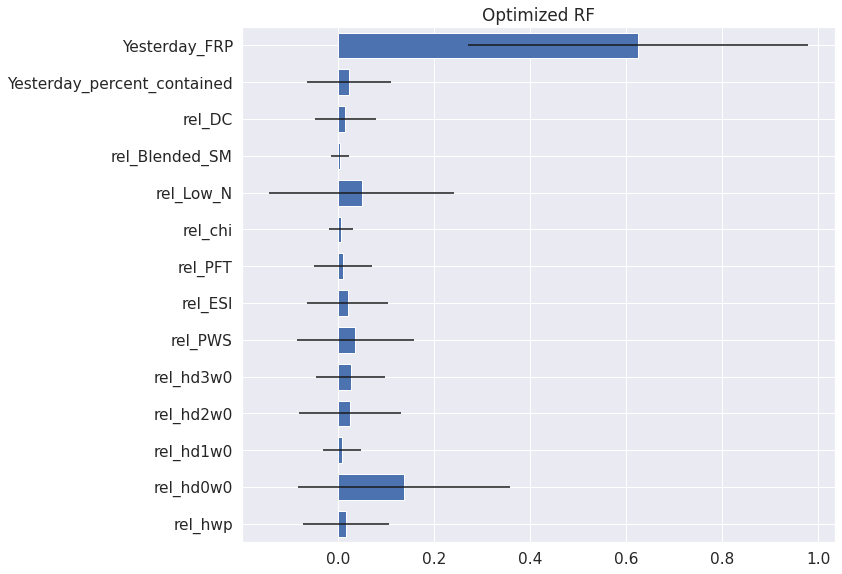


AUCs:
Persistence: 20483.606557377057
Optimized: 15991.803278688521


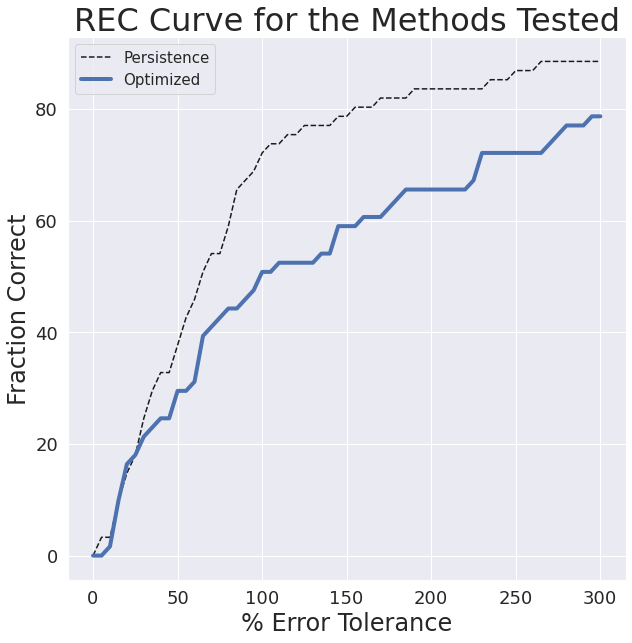

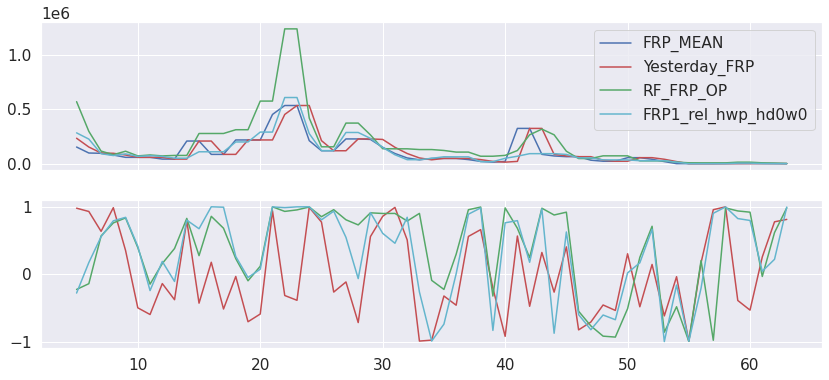

Average rolling R2s:
Persistence:0.026260070408698523
Optimized:0.37296125715633743
HDW and HWP Scaled:0.29196455224457146


In [24]:
inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

inci_test = ['AUGUST COMPLEX']

"""inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                   'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH','AUGUST COMPLEX','CZU', 'SCU' ]
inci_test = ['BOBCAT']"""

data_train= combine_fires(inci_train) #train on not august complex (250 points, 79% of days)
data_test = combine_fires(inci_test) #test on august complex (69 points, 21% of days)

#remove nans
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

data_train_nonan = data_train.dropna(axis=0)
data_test_nonan = data_test.dropna(axis=0)


tv_op=['rel_hwp','rel_hd0w0','rel_hd1w0','rel_hd2w0','rel_hd3w0',#weather
        'rel_PWS', 'rel_ESI', #Soil/fuel characteristics
        'rel_PFT','rel_chi',#stability
        'rel_Low_N',#fuel 
        'rel_Blended_SM','rel_DC', #moisture
                    'Yesterday_percent_contained', #firefighting, 
                    'Yesterday_FRP'] #persistence"""

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['rel_FRP']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
labels_test['rel_FRP_op'] = rf_frp_op
labels_test['RF_FRP_OP'] = labels_test['Yesterday_FRP']*rf_frp_op
labels_test['FRP1_rel_hwp'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']
labels_test['FRP1_rel_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hd0w0']
labels_test['FRP1_rel_hwp_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']*labels_test['rel_hd0w0']



for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_OP', 'FRP1_rel_hwp', 'FRP1_rel_hd0w0', 'FRP1_rel_hwp_hd0w0'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

plot_importances(rf_op, tv_op,'Optimized RF')


#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['FRP_MEAN'].values)
thresh_op, accuracies_op = REC(labels_test['RF_FRP_OP'].values, labels_test['FRP_MEAN'].values)

print()
print('AUCs:')
print('Persistence: ' + str(AUC(accuracy_persistence)))
print('Optimized: ' + str(AUC(accuracies_op)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_op, accuracies_op,'b-',linewidth=4,label='Optimized')
plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


#rolling window
windowsize = 3
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
labels_test.rolling(window=windowsize,center=True).median().plot(y=['FRP_MEAN','Yesterday_FRP', 'RF_FRP_OP', 
                                                                    'FRP1_rel_hwp_hd0w0'],ax=ax[0], 
                                                        style=['b-','r-','g-', 'c-'])
#persistence
rolling_r_pers = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['Yesterday_FRP'])
rolling_r_pers.plot(ax=ax[1], style='r-')

#Kitchen Sink
rolling_r_op = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_OP'])
rolling_r_op.plot(ax=ax[1], style='g-')

#HWP and HD0W0 Scaled
rolling_r_sc_hwp_hd0w0 = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['FRP1_rel_hwp_hd0w0'])
rolling_r_sc_hwp_hd0w0.plot(ax=ax[1], style='c-')
plt.show()

print('Average rolling R2s:')
print('Persistence:' + str(np.nanmean(rolling_r_pers.values)))
print('Optimized:' + str(np.nanmean(rolling_r_op.values)))
print('HDW and HWP Scaled:' + str(np.nanmean(rolling_r_sc_hwp_hd0w0.values)))


204_cow
granite_gulch
shady
williams_flats
pedro_mountain
walker
bobcat
cameron_peak
creek
dolan
east_troublesome
holiday_farm
lake
riverside
pine_gulch
czu
scu
august_complex


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


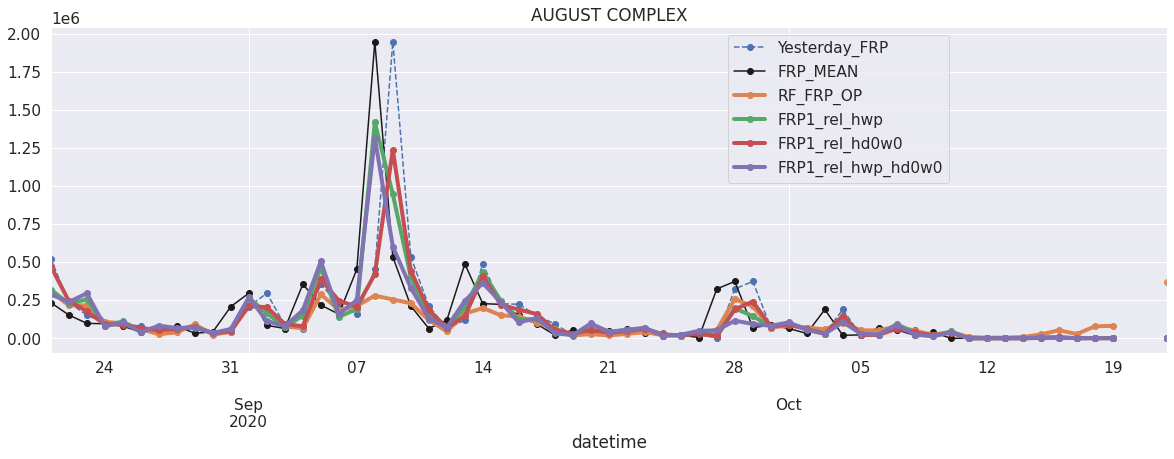

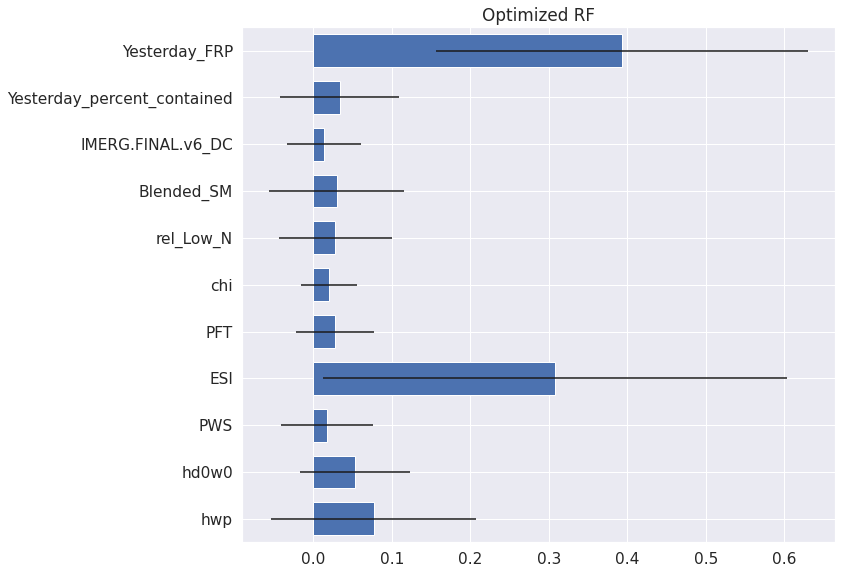


AUCs:
Persistence: 20483.606557377057
Optimized: 19172.131147540975


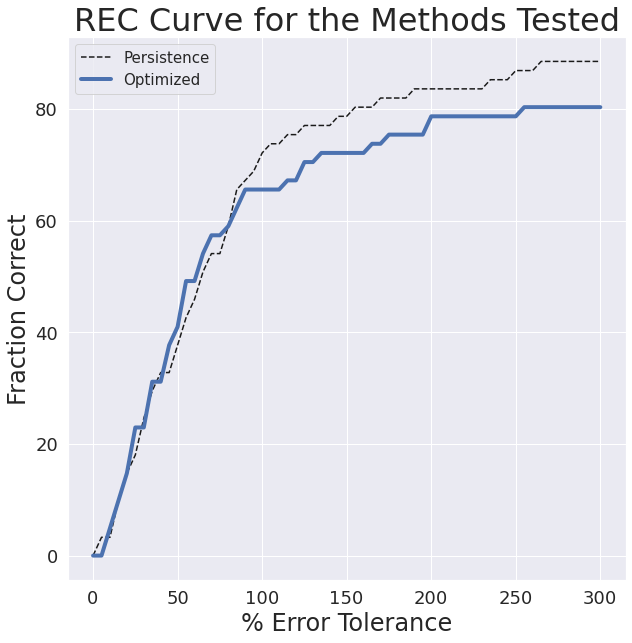

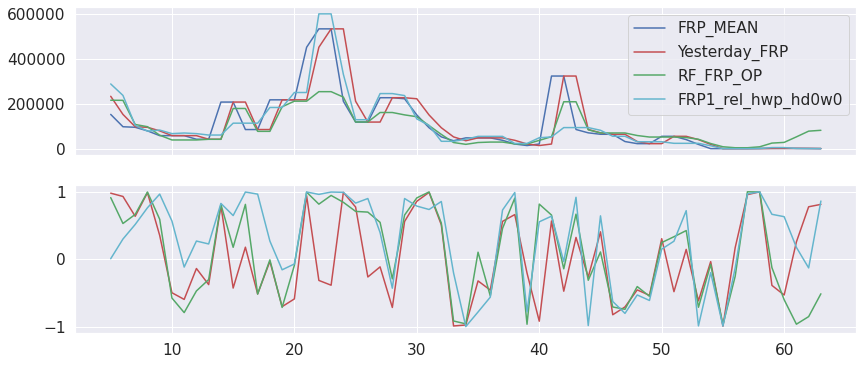

Average rolling R2s:
Persistence:0.026260070408698523
Optimized:0.09754674079767936
HDW and HWP Scaled:0.27835606567718757


In [29]:
inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

inci_test = ['AUGUST COMPLEX']

"""inci_train = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                   'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH','AUGUST COMPLEX','CZU', 'SCU' ]
inci_test = ['BOBCAT']"""

data_train= combine_fires_unweighted(inci_train) #train on not august complex (250 points, 79% of days)
data_test = combine_fires_unweighted(inci_test) #test on august complex (69 points, 21% of days)

#remove nans
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

data_train_nonan = data_train.dropna(axis=0)
data_test_nonan = data_test.dropna(axis=0)


"""tv_op=['rel_hwp','rel_hd0w0','rel_hd1w0','rel_hd2w0','rel_hd3w0',#weather
        'rel_PWS', 'rel_ESI', #Soil/fuel characteristics
        'rel_PFT','rel_chi',#stability
        'rel_Low_N',#fuel 
        'rel_Blended_SM','rel_DC', #moisture
        'Yesterday_percent_contained', #firefighting, 
        'Yesterday_FRP'] #persistence"""

tv_op=['hwp','hd0w0',#weather
        'PWS', 'ESI', #Soil/fuel characteristics
        'PFT','chi',#stability
        'rel_Low_N',#fuel 
        'Blended_SM','IMERG.FINAL.v6_DC', #moisture
        'Yesterday_percent_contained', #firefighting, 
        'Yesterday_FRP'] #persistence

rf_op = RandomForestRegressor(oob_score=True,min_samples_leaf=5, random_state= 42) #scaling is not necessary!
rf_op.fit(data_train_nonan.loc[:, tv_op], data_train_nonan.loc[:, ['FRP_MEAN']])
rf_frp_op = rf_op.predict(data_test_nonan.loc[:,tv_op])

labels_test = data_test_nonan
#labels_test['rel_FRP_op'] = rf_frp_op
labels_test['RF_FRP_OP'] = rf_frp_op
labels_test['FRP1_rel_hwp'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']
labels_test['FRP1_rel_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hd0w0']
labels_test['FRP1_rel_hwp_hd0w0'] = labels_test['Yesterday_FRP']*labels_test['rel_hwp']*labels_test['rel_hd0w0']



for ii in range(len(inci_test)):
    labels_plot = resample_daily(labels_test[labels_test['name']==inci_test[ii]], 'datetime')
    #plot the predictions
    fig, ax = plt.subplots(figsize=(20,15)) 
    labels_plot.plot(x='datetime', y=['Yesterday_FRP'],
                                figsize=(20,6),style='o--',ax=ax )
    labels_plot.plot(x='datetime', y=['FRP_MEAN'],
                                figsize=(20,6),style='ko-',ax=ax )
    labels_plot.plot(x='datetime', y=['RF_FRP_OP', 'FRP1_rel_hwp', 'FRP1_rel_hd0w0', 'FRP1_rel_hwp_hd0w0'],
                                figsize=(20,6),style='o-',linewidth=4,ax=ax)
    

    #h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(0.6, 1), loc='upper left')
    plt.title(inci_test[ii])
    plt.show()  

plot_importances(rf_op, tv_op,'Optimized RF')


#REC CURVES
thresholds_persistence, accuracy_persistence = REC(labels_test['Yesterday_FRP'].values, labels_test['FRP_MEAN'].values)
thresh_op, accuracies_op = REC(labels_test['RF_FRP_OP'].values, labels_test['FRP_MEAN'].values)

print()
print('AUCs:')
print('Persistence: ' + str(AUC(accuracy_persistence)))
print('Optimized: ' + str(AUC(accuracies_op)))



plt.figure(figsize=(10,10))
plt.plot(thresholds_persistence, accuracy_persistence,'k--',  label = 'Persistence')
plt.plot(thresh_op, accuracies_op,'b-',linewidth=4,label='Optimized')
plt.legend(fontsize=15)
plt.title('REC Curve for the Methods Tested', fontsize=32)
plt.ylabel('Fraction Correct', fontsize=24)
plt.xlabel('% Error Tolerance', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


#rolling window
windowsize = 3
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
labels_test.rolling(window=windowsize,center=True).median().plot(y=['FRP_MEAN','Yesterday_FRP', 'RF_FRP_OP', 
                                                                    'FRP1_rel_hwp_hd0w0'],ax=ax[0], 
                                                        style=['b-','r-','g-', 'c-'])
#persistence
rolling_r_pers = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['Yesterday_FRP'])
rolling_r_pers.plot(ax=ax[1], style='r-')

#Kitchen Sink
rolling_r_op = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['RF_FRP_OP'])
rolling_r_op.plot(ax=ax[1], style='g-')

#HWP and HD0W0 Scaled
rolling_r_sc_hwp_hd0w0 = labels_test['FRP_MEAN'].rolling(window=windowsize, center=True).corr(labels_test['FRP1_rel_hwp_hd0w0'])
rolling_r_sc_hwp_hd0w0.plot(ax=ax[1], style='c-')
plt.show()

print('Average rolling R2s:')
print('Persistence:' + str(np.nanmean(rolling_r_pers.values)))
print('Optimized:' + str(np.nanmean(rolling_r_op.values)))
print('HDW and HWP Scaled:' + str(np.nanmean(rolling_r_sc_hwp_hd0w0.values)))


# Compare new rave with old rave

In [ ]:
# line plots of FRP from all test cases, daily sum of FRP for 3km data
fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
    
    if exists(path_features_coarse+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv'):
        rave_coarse = pd.read_csv(path_features_coarse+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
        
        fig, ax = plt.subplots(figsize=(20,15)) 
        rave.plot(x='day', y=['FRP_MEAN'],
                            figsize=(20,6),style='ro-',ax=ax )
        rave_coarse.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
        h1, l1 = ax.get_legend_handles_labels()
        ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
        plt.title(fire_incidents[ii])
        plt.show()
        
    else:
        fig, ax = plt.subplots(figsize=(20,15)) 
        rave.plot(x='day', y=['FRP_MEAN'],
                            figsize=(20,6),style='ro-',ax=ax )
        h1, l1 = ax.get_legend_handles_labels()
        ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
        plt.title(fire_incidents[ii])
        plt.show()
        

# look at FWI

In [ ]:
# line plots of FRP from all test cases, daily sum of FRP for 3km data
fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']

path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
    fwi = pd.read_csv(path_features+file_prefix+'_Daily_FWI_IMERG_'+str(start_time)+'Z_day_start.csv')
    pft = pd.read_csv(path_features+file_prefix+'_Daily_PFT_'+str(start_time)+'Z_day_start.csv')
    pft['pft_mw'] = pft['PFT']*1000    
    fig, ax = plt.subplots(figsize=(20,15)) 
    """fwi.plot(x='day', y=['IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='o-',ax=ax )"""
    pft.plot(x='day', y=['pft_mw'],
                            figsize=(20,6),style='o-',ax=ax )
    rave.plot(x='day', y=['FRP_MEAN'],secondary_y=True,
                                figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(fire_incidents[ii])
    plt.show()

        